# 美国议员立法行为预测分析

本笔记本分析美国议员在不同议题上推动立法的行为模式，通过LightGBM模型预测议员的立法倾向，并识别影响立法行为的关键因素。

## 分析目标
- 预测美国议员在特定议题上的立法行为
- 识别影响议员立法决策的关键特征
- 分析国际响应型、专业选择型、利益兑现型三种立法动机模式

## 数据说明
- **标签（label）**: 议员是否在该议题上进行立法推动（1=立法，0=不立法）
- **特征**: 包括议员基础信息、议题特征、选区特征、匹配特征等

## 目录
1. [数据准备](#数据准备)
2. [特征工程](#特征工程) 
3. [模型训练](#模型训练)
4. [模型评估](#模型评估)
5. [SHAP解释性分析](#SHAP解释性分析)
6. [决策模式分析](#决策模式分析)
7. [排名分析](#排名分析)

## 1. 数据准备

### 1.1 导入必要的库

导入数据处理、机器学习和可视化所需的Python库。

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### 1.2 加载数据

加载美国议员立法行为训练数据，了解数据的基本结构和特征分布。

In [9]:
origin_data = pd.read_csv("output/legis_train_data.csv")
data = origin_data
data.shape

(68640, 53)

### 1.3 数据概览

查看数据的列名和基本信息，为后续的特征分析做准备。

In [10]:
data.columns

Index(['issue', 'leverage', 'state_code', 's_committee_tp1', 's_committee_tp2',
       's_committee_tp3', 'h_committee_tp1', 'h_committee_tp2',
       'h_committee_tp3', 'party_tp_type', 'party_tp_score', 'industry_tp1',
       'industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'full_name', 'congress', 'age', 'gender', 'party',
       'chamber', 'seniority', 'ideology', 'committee_el', 'district',
       'employ1', 'employ2', 'employ3', 'payroll1', 'payroll2', 'payroll3',
       'ethnicity1', 'ethnicity2', 'ethnicity3', 'ppvi', 'npvi', 'leverage_pl',
       'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl',
       'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne',
       'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne',
       'party_score_pl', 'party_score_ne', 'label'],
      dtype='object')

In [11]:
# 数据列名分类整理
columns_by_category = {
    # 标识信息
    "标识信息": [
        'issue',           # 议题名称
        'full_name',       # 议员姓名  
        'congress',        # 国会届数
        'label'            # 标签
    ],
    
    # 基础议员特征
    "基础议员特征": [
        'age',             # 年龄
        'gender',          # 性别
        'party',           # 党派
        'chamber',         # 议院
        'seniority',       # 资历
        'ideology',        # 意识形态
        'committee_el',    # 议员委员会
        'district',         # 选区
        'state_code',           # 州
    ],
    
    # 议题特征
    "议题特征": [
        'leverage',        # 议题国际压力值
        'party_tp_type',   # 政党偏好类别
        'party_tp_score',  # 政党偏好分数
    ],
    
    # 议题委员会特征
    "议题委员会特征": [
        's_committee_tp1', # 参议院委员会1
        's_committee_tp2', # 参议院委员会2
        's_committee_tp3', # 参议院委员会3
        'h_committee_tp1', # 众议院委员会1
        'h_committee_tp2', # 众议院委员会2
        'h_committee_tp3'  # 众议院委员会3
    ],
    
    # 议题产业特征
    "议题产业特征": [
        'industry_tp1',    # 产业卷入度1
        'industry_tp2',    # 产业卷入度2
        'industry_tp3'     # 产业卷入度3
    ],
    
    # 议题族裔特征
    "议题族裔特征": [
        'ethnicity_tp1',   # 族裔卷入度1
        'ethnicity_tp2',   # 族裔卷入度2
        'ethnicity_tp3'    # 族裔卷入度3
    ],
    
    # 选区产业特征
    "选区产业特征": [
        'employ1',         # 雇佣产业1
        'employ2',         # 雇佣产业2
        'employ3',         # 雇佣产业3
        'payroll1',        # 金主产业1
        'payroll2',        # 金主产业2
        'payroll3'         # 金主产业3
    ],
    
    # 选区族裔特征
    "选区族裔特征": [
        'ethnicity1',      # 选区族裔1
        'ethnicity2',      # 选区族裔2
        'ethnicity3'       # 选区族裔3
    ],
    
    # 选区政治特征
    "选区政治特征": [
        'ppvi',            # 政党类别
        'npvi'             # 投票倾向指数
    ],
    
    # 匹配特征 - 国际压力
    "匹配特征-国际压力": [
        'leverage_pl',     # 国际压力值正特征
        'leverage_ne'      # 国际压力值负特征
    ],
    
    # 匹配特征 - 委员会
    "匹配特征-委员会": [
        'committee_pl',    # 委员会匹配值正特征
        'committee_ne'     # 委员会匹配值负特征
    ],
    
    # 匹配特征 - 产业
    "匹配特征-产业": [
        'employ_industry_pl',   # 雇佣产业匹配值正特征
        'employ_industry_ne',   # 雇佣产业匹配值负特征
        'payroll_industry_pl',  # 金主产业匹配值正特征
        'payroll_industry_ne'   # 金主产业匹配值负特征
    ],
    
    # 匹配特征 - 族裔
    "匹配特征-族裔": [
        'ethnicity_pl',    # 族裔匹配值正特征
        'ethnicity_ne'     # 族裔匹配值负特征
    ],
    
    # 匹配特征 - 政党
    "匹配特征-政党": [
        'party_value_pl',  # 政党类别匹配值正特征
        'party_value_ne',  # 政党类别匹配值负特征
        'party_score_pl',  # 政党分数匹配值正特征
        'party_score_ne'   # 政党分数匹配值负特征
    ]
}

# 打印分类结果
for category, columns in columns_by_category.items():
    print(f"\n{category} ({len(columns)}个特征):")
    for col in columns:
        print(f"  - {col}")

# 验证是否包含所有列
all_categorized_columns = []
for columns in columns_by_category.values():
    all_categorized_columns.extend(columns)

print(f"\n总共分类了 {len(all_categorized_columns)} 个特征")
print(f"原数据共有 {len(data.columns)} 个特征")

# 检查是否有遗漏的列
missing_columns = set(data.columns) - set(all_categorized_columns)
if missing_columns:
    print(f"\n未分类的列: {missing_columns}")
else:
    print("\n✓ 所有列都已分类")


标识信息 (4个特征):
  - issue
  - full_name
  - congress
  - label

基础议员特征 (9个特征):
  - age
  - gender
  - party
  - chamber
  - seniority
  - ideology
  - committee_el
  - district
  - state_code

议题特征 (3个特征):
  - leverage
  - party_tp_type
  - party_tp_score

议题委员会特征 (6个特征):
  - s_committee_tp1
  - s_committee_tp2
  - s_committee_tp3
  - h_committee_tp1
  - h_committee_tp2
  - h_committee_tp3

议题产业特征 (3个特征):
  - industry_tp1
  - industry_tp2
  - industry_tp3

议题族裔特征 (3个特征):
  - ethnicity_tp1
  - ethnicity_tp2
  - ethnicity_tp3

选区产业特征 (6个特征):
  - employ1
  - employ2
  - employ3
  - payroll1
  - payroll2
  - payroll3

选区族裔特征 (3个特征):
  - ethnicity1
  - ethnicity2
  - ethnicity3

选区政治特征 (2个特征):
  - ppvi
  - npvi

匹配特征-国际压力 (2个特征):
  - leverage_pl
  - leverage_ne

匹配特征-委员会 (2个特征):
  - committee_pl
  - committee_ne

匹配特征-产业 (4个特征):
  - employ_industry_pl
  - employ_industry_ne
  - payroll_industry_pl
  - payroll_industry_ne

匹配特征-族裔 (2个特征):
  - ethnicity_pl
  - ethnicity_ne

匹配特征-政党 (4个特征):
  - 

## 2. 特征工程

### 2.1 特征选择

基于前期分析，选择14个核心匹配特征进行模型训练。这些特征主要反映议员与议题之间的匹配度，包括：
- 国际压力匹配特征
- 委员会专业匹配特征  
- 产业利益匹配特征
- 族裔利益匹配特征
- 政党立场匹配特征

In [12]:
# data = data.drop(["state_code"], axis=1)

In [13]:
# data["npvi"] = data["npvi"].replace("Even", np.nan)
# data["npvi"] = data["npvi"].astype(float)

In [14]:
# categorical_features = [
#    'state_code',
#    'party_tp_type', 
#    # 'district',
#    'industry_tp1', 'industry_tp2', 'industry_tp3',
#    'ethnicity_tp1', 'ethnicity_tp2', 'ethnicity_tp3',
#    's_committee_tp1', 's_committee_tp2', 's_committee_tp3', 
#    'h_committee_tp1', 'h_committee_tp2', 'h_committee_tp3',
#    "chamber", "party", "gender", "committee_el", 
#    'employ1', 'employ2', 'employ3', 
#    "payroll1", "payroll2", "payroll3",
#    "ethnicity1", "ethnicity2", "ethnicity3",
#    'ppvi', 'npvi', 'leverage_pl',
#    'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl',
#    'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne',
#    'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne',
#    'party_score_pl', 'party_score_ne'
# ]

In [15]:
# 更新分类特征列表（只包含您选定的特征）
categorical_features = [
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne',
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne'
]

### 2.2 特征编码

将分类特征转换为数值编码，为LightGBM模型训练做准备。

In [16]:
for col in categorical_features:
    data[col] = data[col].astype('category').cat.codes

### 2.3 数据划分和特征提取

按照7:3的比例划分训练集和测试集，仅保留选定的14个匹配特征进行模型训练。

In [17]:
# # 划分训练集和测试集
# train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# # 筛选特征用
# test_data_pred = test_data[["issue", "full_name", "congress","district", "label"]]

# # 移除非特征列
# train_data = train_data.drop(["issue", "full_name", "congress","district"], axis=1)
# test_data = test_data.drop(["issue",  "full_name", "congress","district", "label"], axis=1)

# print("训练集大小：", train_data.shape[0], " 测试集大小：", test_data.shape[0])

# train_data = train_data.reset_index(drop=True)
# test_data = test_data.reset_index(drop=True)

# a = train_data[train_data["label"] == 1].shape[0]
# b = train_data[train_data["label"] == 0].shape[0]
# print("正样本：", a, "负样本：", b, "负样本/正样本：", b/a)

# train_label = train_data['label']
# train_data = train_data.drop("label", axis=1)

In [18]:
# =============================
# （LEGIS 版）自变量成组偏态处理
# 目标：与 adver 版本结构/内容一致，仅将输出等改为 legis
# 输出：output/legis_train_adj.csv, output/legis_test_adj.csv
# =============================

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# =============================
# 1) 定义特征 & 划分数据（结构保持不变）
# =============================
selected_features = [
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne'
]

# 你应当已事先有 data DataFrame（含 label 列）
# 例如：data = pd.read_csv("output/legis_train_data.csv")

# 划分训练集和测试集（保持你的写法）
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 筛选特征用（保留标识信息）
test_data_pred = test_data[["issue", "full_name", "congress", "district", "label"]]

# 保存完整的测试数据（包含标识信息和特征）
test_data_pred_merged = test_data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()

# 创建 data_pred 并添加 dataset 列
data_pred = data[["issue", "full_name", "congress", "district", "label"]].copy()
data_pred['dataset'] = 'unknown'  # 默认值
data_pred.loc[train_data.index, 'dataset'] = 'train'
data_pred.loc[test_data.index, 'dataset'] = 'test'

data_pred_merged = data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()
data_pred_merged['dataset'] = 'unknown'  # 默认值
data_pred_merged.loc[train_data.index, 'dataset'] = 'train'
data_pred_merged.loc[test_data.index, 'dataset'] = 'test'

# 只保留指定的特征列和标签列
train_data = train_data[selected_features + ['label']]
test_data  = test_data[selected_features]

print("训练集大小：", train_data.shape[0], " 测试集大小：", test_data.shape[0])
print("特征数量：", len(selected_features))

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

# ========== 拟合用的标签先取出 ==========
train_label = train_data['label'].copy()
train_feats = train_data.drop(columns=['label']).copy()  # 仅特征
test_feats  = test_data.copy()

# ========= 引入依赖 =========
# （已在顶部 import）

# ========= 处理策略（组内一致）=========
WINSOR_COLS = [
    # 轻/中度偏态：缩尾（组内一致）
    "leverage_pl", "leverage_ne",
    "employ_industry_pl", "employ_industry_ne",
    "party_score_pl", "party_score_ne"
]
LOG_COLS = [
    # 严重偏态：log(1+x)（组内一致）
    "committee_pl", "committee_ne",
    "payroll_industry_pl", "payroll_industry_ne"
]
STD_GROUPS = [
    # 需要做标准化的成组列（避免一边重偏态一边不处理）
    ["ethnicity_pl", "ethnicity_ne"]
]

# ========= 从训练集拟合参数（避免泄露）=========
# 1) 缩尾参数：按训练集分位数拟合
def fit_winsor_params(df, cols, lower=0.01, upper=0.99):
    params = {}
    for c in cols:
        s = df[c]
        params[c] = (float(s.quantile(lower)), float(s.quantile(upper)))
    return params

# 2) log(1+x) 偏移量：按训练集最小值拟合
def fit_log_shift(df, cols):
    shifts = {}
    for c in cols:
        mn = float(df[c].min())
        # 确保 1 + (x + shift) >= 1
        shift = 1 - mn if mn < 0 else 1.0
        shifts[c] = shift
    return shifts

# 3) 标准化器（按组拟合）
def fit_scalers(df, groups):
    scalers = {}
    for g in groups:
        scaler = StandardScaler()
        scaler.fit(df[g])
        scalers[tuple(g)] = scaler
    return scalers

winsor_params = fit_winsor_params(train_feats, WINSOR_COLS, 0.01, 0.99)
log_shifts    = fit_log_shift(train_feats, LOG_COLS)
scalers_map   = fit_scalers(train_feats, STD_GROUPS)

# ========= 应用变换（先于合并标签）=========
def apply_winsor(df, params):
    df2 = df.copy()
    for c, (lo, hi) in params.items():
        if c in df2.columns:
            df2[c] = df2[c].clip(lo, hi)
    return df2

def apply_log1p(df, shifts):
    df2 = df.copy()
    for c, shift in shifts.items():
        if c in df2.columns:
            df2[c] = np.log1p(df2[c] + shift)
    return df2

def apply_scalers(df, scalers_map):
    df2 = df.copy()
    for cols_tuple, scaler in scalers_map.items():
        cols = list(cols_tuple)
        exist = [c for c in cols if c in df2.columns]
        if exist:
            df2[exist] = scaler.transform(df2[exist])
    return df2

# —— 对训练集特征应用：先缩尾 → 再 log → 再标准化（组内一致）
train_feats_adj = apply_winsor(train_feats, winsor_params)
train_feats_adj = apply_log1p(train_feats_adj, log_shifts)
train_feats_adj = apply_scalers(train_feats_adj, scalers_map)

# —— 对测试集特征应用：使用训练集拟合的同一套参数
test_feats_adj = apply_winsor(test_feats, winsor_params)
test_feats_adj = apply_log1p(test_feats_adj, log_shifts)
test_feats_adj = apply_scalers(test_feats_adj, scalers_map)

# ========= 回填到训练变量名，保证与你后续训练代码对齐 =========
train_data = train_feats_adj.copy()       # 训练特征矩阵
test_data  = test_feats_adj.copy()        # 测试特征矩阵
# 保持你原来的命名：train_label 仍为标签向量
print("调整后训练特征维度：", train_data.shape, " 调整后测试特征维度：", test_data.shape)

# ⚠️ 新增：输出正负样本数量
a = (train_label == 1).sum()
b = (train_label == 0).sum()
print("正样本：", a, "负样本：", b, "负样本/正样本：", b/a)

# ========= 导出（LEGIS 版文件名）=========
os.makedirs("output", exist_ok=True)
pd.concat([train_data, train_label], axis=1).to_csv("output/legis_train_adj.csv", index=False)
test_data.to_csv("output/legis_test_adj.csv", index=False)
print("已保存：output/legis_train_adj.csv, output/legis_test_adj.csv")

# ========= 训练前的最终检查（与你原来的打印保持一致）=========
print("最终训练特征：", list(train_data.columns))
print("特征数量验证：", len(train_data.columns))
print("训练样本数：", train_label.shape[0], "测试样本数：", test_data.shape[0])

# （到这里为止，直接把 train_data / train_label / test_data 交给你的 LightGBM 代码即可）

训练集大小： 48048  测试集大小： 20592
特征数量： 14
调整后训练特征维度： (48048, 14)  调整后测试特征维度： (20592, 14)
正样本： 30089 负样本： 17959 负样本/正样本： 0.5968626408321979
已保存：output/legis_train_adj.csv, output/legis_test_adj.csv
最终训练特征： ['leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne']
特征数量验证： 14
训练样本数： 48048 测试样本数： 20592


In [19]:
# =============================
# （LEGIS 版）自变量分箱处理（与 adver 版结构/格式完全对齐）
# 仅针对 selected_features（pl/ne 系列）进行等频分箱（训练集拟合 → 测试集复用）
# 输出：分箱版（output/legis_train_binned.csv / output/legis_test_binned.csv）
# =============================

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# =============================
# 1) 定义特征 & 划分数据（与你的原始流程一致）
# =============================
selected_features = [
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne'
]

# —— 你应当已事先有 data DataFrame（含 label 列）
# 例如：data = pd.read_csv("output/legis_train_data.csv")

# 划分训练集和测试集（保持你的写法）
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 筛选特征用（保留标识信息）
test_data_pred = test_data[["issue", "full_name", "congress", "district", "label"]]

# 保存完整的测试数据（包含标识信息和特征）
test_data_pred_merged = test_data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()

# 创建 data_pred 并添加 dataset 列
data_pred = data[["issue", "full_name", "congress", "district", "label"]].copy()
data_pred['dataset'] = 'unknown'  # 默认值
data_pred.loc[train_data.index, 'dataset'] = 'train'
data_pred.loc[test_data.index, 'dataset'] = 'test'

data_pred_merged = data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()
data_pred_merged['dataset'] = 'unknown'
data_pred_merged.loc[train_data.index, 'dataset'] = 'train'
data_pred_merged.loc[test_data.index, 'dataset'] = 'test'

# 只保留指定的特征列和标签列
train_data = train_data[selected_features + ['label']]
test_data  = test_data[selected_features]

print("训练集大小：", train_data.shape[0], " 测试集大小：", test_data.shape[0])
print("特征数量：", len(selected_features))

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

# ========== 拟合用的标签先取出 ==========
train_label = train_data['label'].copy()
train_feats = train_data.drop(columns=['label']).copy()  # 仅特征
test_feats  = test_data.copy()

# ========= 分箱处理（等频分箱，训练集拟合 → 测试集复用）=========
def _expand_bins(bins, eps=1e-9):
    """略微扩展边界，避免测试集值落在边界外产生 NaN"""
    bins = bins.copy()
    bins[0]  = bins[0]  - eps
    bins[-1] = bins[-1] + eps
    return bins

def fit_binning(train_df, n_bins=5):
    """
    基于训练集为每个特征拟合等频分箱的边界（qcut）。
    返回：{col: bins(ndarray)}
    """
    bin_map = {}
    for col in train_df.columns:
        s = train_df[col]
        try:
            # qcut 拟合分箱点（duplicates='drop' 以防唯一值不足）
            _, bins = pd.qcut(s, q=n_bins, retbins=True, duplicates="drop")
            bins = _expand_bins(bins)
            bin_map[col] = bins
        except Exception as e:
            # 回退策略：按唯一值个数自适应；仍失败则不分箱
            uniq = s.dropna().unique()
            if len(uniq) > 1:
                # 用等距分箱作为兜底
                bins = np.linspace(s.min(), s.max(), num=min(n_bins, len(uniq)) + 1)
                bins = np.unique(bins)
                if len(bins) >= 2:
                    bins = _expand_bins(bins)
                    bin_map[col] = bins
                    continue
            print(f"⚠️ 分箱拟合失败：{col}，保留原值。原因：{e}")
    return bin_map

def apply_binning(df, bin_map):
    """
    将拟合好的分箱边界应用到给定数据，输出为整数标签（0..K-1）。
    对于未能拟合分箱的列，保留原值。
    """
    out = df.copy()
    for col in df.columns:
        if col in bin_map:
            try:
                out[col] = pd.cut(df[col], bins=bin_map[col],
                                  labels=False, include_lowest=True)
                # 若仍有 NaN（极端越界/全空），用中位数箱填充
                if out[col].isna().any():
                    med_bin = int(np.nanmedian(out[col].values))
                    out[col] = out[col].fillna(med_bin)
            except Exception as e:
                print(f"⚠️ 分箱应用失败：{col}，保留原值。原因：{e}")
        # 若不在 bin_map（拟合失败），就保持原值不变
    return out

# —— 拟合训练集分箱
bin_edges_map = fit_binning(train_feats, n_bins=5)

# —— 应用到训练/测试
train_feats_binned = apply_binning(train_feats, bin_edges_map)
test_feats_binned  = apply_binning(test_feats,  bin_edges_map)

# ========= 回填到训练变量名，保证与你后续训练代码对齐 =========
train_data = train_feats_binned.copy()       # 训练特征矩阵（分箱后的整数标签）
test_data  = test_feats_binned.copy()        # 测试特征矩阵（分箱后的整数标签）
print("分箱后训练特征维度：", train_data.shape, " 分箱后测试特征维度：", test_data.shape)

# ⚠️ 输出正负样本数量（与你原始输出一致）
a = (train_label == 1).sum()
b = (train_label == 0).sum()
print("正样本：", a, "负样本：", b, "负样本/正样本：", b / a if a else np.nan)

# ========= 导出（LEGIS 版的文件名）=========
os.makedirs("output", exist_ok=True)
pd.concat([train_data, train_label], axis=1).to_csv("output/legis_train_binned.csv", index=False)
test_data.to_csv("output/legis_test_binned.csv", index=False)
print("已保存：output/legis_train_binned.csv, output/legis_test_binned.csv")

# ========= 训练前的最终检查（与你原来的打印保持一致）=========
print("最终训练特征：", list(train_data.columns))
print("特征数量验证：", len(train_data.columns))
print("训练样本数：", train_label.shape[0], "测试样本数：", test_data.shape[0])

# （到这里为止，直接把 train_data / train_label / test_data 交给你的 LightGBM 代码即可）

训练集大小： 48048  测试集大小： 20592
特征数量： 14
分箱后训练特征维度： (48048, 14)  分箱后测试特征维度： (20592, 14)
正样本： 30089 负样本： 17959 负样本/正样本： 0.5968626408321979
已保存：output/legis_train_binned.csv, output/legis_test_binned.csv
最终训练特征： ['leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne']
特征数量验证： 14
训练样本数： 48048 测试样本数： 20592


In [20]:
# =============================
# 自变量成组偏态处理（LEGIS 版，含 seniority / npvi 特殊规则）
# 输出：output/legis_train_adj.csv, output/legis_test_adj.csv
# =============================

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# =============================
# 1) 定义特征 & 划分数据（保持你的原始流程与打印）
# =============================
selected_features = [
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne',
    # ===== 议员特征（与分析结论一致）=====
    'age', 'gender', 'congress', 'seniority', 'ideology', 'npvi'
]

# 你应当已事先有 data DataFrame（含 label 列）
# 例如：data = pd.read_csv("output/legis_train_data.csv")

# 划分训练集和测试集（保持你的写法）
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 筛选特征用（保留标识信息）
test_data_pred = test_data[["issue", "full_name", "congress", "district", "label"]]

# 保存完整的测试数据（包含标识信息和特征）
test_data_pred_merged = test_data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()

# 创建 data_pred 并添加 dataset 列
data_pred = data[["issue", "full_name", "congress", "district", "label"]].copy()
data_pred['dataset'] = 'unknown'  # 默认值
data_pred.loc[train_data.index, 'dataset'] = 'train'
data_pred.loc[test_data.index, 'dataset'] = 'test'

data_pred_merged = data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()
data_pred_merged['dataset'] = 'unknown'
data_pred_merged.loc[train_data.index, 'dataset'] = 'train'
data_pred_merged.loc[test_data.index, 'dataset'] = 'test'

# 只保留指定的特征列和标签列
train_data = train_data[selected_features + ['label']]
test_data  = test_data[selected_features]

print("训练集大小：", train_data.shape[0], " 测试集大小：", test_data.shape[0])
print("特征数量：", len(selected_features))

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

# ========== 拟合用的标签先取出 ==========
train_label = train_data['label'].copy()
train_feats = train_data.drop(columns=['label']).copy()  # 仅特征
test_feats  = test_data.copy()

# ========= 处理策略（组内一致 + 议员变量规则）=========
# —— 根据 legis 的检查结果：
#   严重偏态：committee_*、payroll_industry_* → log(1+x)
#   轻/中度偏态：leverage_pl/ne、employ_industry_*、party_score_*、seniority → winsorize
#   成组尺度一致：ethnicity_pl/ne → 标准化
#   npvi 基本正常 → 可选标准化（默认开）；age/gender/congress/ideology 保留原值

# 轻/中度偏态：缩尾（组内一致）
WINSOR_COLS = [
    "leverage_pl", "leverage_ne",
    "employ_industry_pl", "employ_industry_ne",
    "party_score_pl", "party_score_ne",
    # 议员变量：seniority 轻度偏态 → 做缩尾
    "seniority"
]
# 严重偏态：log(1+x)（组内一致）
LOG_COLS = [
    "committee_pl", "committee_ne",
    "payroll_industry_pl", "payroll_industry_ne"
]
# 组标准化（保持之前 ethnicity 成组一致）
STD_GROUPS = [
    ["ethnicity_pl", "ethnicity_ne"]
]
# 单列标准化（新增议员变量规则）
NPVI_STANDARDIZE = True   # 可选标准化（根据你的要求，默认开启）
STD_SINGLE = []
if NPVI_STANDARDIZE:
    STD_SINGLE.append("npvi")
# seniority：缩尾后也做标准化，稳健一些
STD_SINGLE.append("seniority")

# ========= 从训练集拟合参数（避免泄露）=========
# 1) 缩尾参数：按训练集分位数拟合
def fit_winsor_params(df, cols, lower=0.01, upper=0.99):
    params = {}
    for c in cols:
        if c in df.columns:
            s = df[c]
            params[c] = (float(s.quantile(lower)), float(s.quantile(upper)))
    return params

# 2) log(1+x) 偏移量：按训练集最小值拟合
def fit_log_shift(df, cols):
    shifts = {}
    for c in cols:
        if c in df.columns:
            mn = float(df[c].min())
            # 确保 1 + (x + shift) >= 1
            shift = 1 - mn if mn < 0 else 1.0
            shifts[c] = shift
    return shifts

# 3) 标准化器（按组 + 单列拟合）
def fit_group_scalers(df, groups):
    scalers = {}
    for g in groups:
        exist = [c for c in g if c in df.columns]
        if not exist: 
            continue
        scaler = StandardScaler()
        scaler.fit(df[exist])
        scalers[tuple(exist)] = scaler
    return scalers

def fit_single_scalers(df, cols):
    scalers = {}
    for c in cols:
        if c in df.columns:
            scaler = StandardScaler()
            scaler.fit(df[[c]])
            scalers[c] = scaler
    return scalers

winsor_params   = fit_winsor_params(train_feats, WINSOR_COLS, 0.01, 0.99)
log_shifts      = fit_log_shift(train_feats, LOG_COLS)
group_scalers   = fit_group_scalers(train_feats, STD_GROUPS)
single_scalers  = fit_single_scalers(train_feats, STD_SINGLE)

# ========= 应用变换（先于合并标签）=========
def apply_winsor(df, params):
    df2 = df.copy()
    for c, (lo, hi) in params.items():
        if c in df2.columns:
            df2[c] = df2[c].clip(lo, hi)
    return df2

def apply_log1p(df, shifts):
    df2 = df.copy()
    for c, shift in shifts.items():
        if c in df2.columns:
            df2[c] = np.log1p(df2[c] + shift)
    return df2

def apply_group_scalers(df, scalers_map):
    df2 = df.copy()
    for cols_tuple, scaler in scalers_map.items():
        cols = list(cols_tuple)
        exist = [c for c in cols if c in df2.columns]
        if exist:
            df2[exist] = scaler.transform(df2[exist])
    return df2

def apply_single_scalers(df, scalers_map):
    df2 = df.copy()
    for c, scaler in scalers_map.items():
        if c in df2.columns:
            df2[[c]] = scaler.transform(df2[[c]])
    return df2

# —— 对训练集特征应用：先缩尾 → 再 log → 再标准化（组/单列）
train_feats_adj = apply_winsor(train_feats, winsor_params)
train_feats_adj = apply_log1p(train_feats_adj, log_shifts)
train_feats_adj = apply_group_scalers(train_feats_adj, group_scalers)
train_feats_adj = apply_single_scalers(train_feats_adj, single_scalers)

# —— 对测试集特征应用：使用训练集拟合的同一套参数
test_feats_adj = apply_winsor(test_feats, winsor_params)
test_feats_adj = apply_log1p(test_feats_adj, log_shifts)
test_feats_adj = apply_group_scalers(test_feats_adj, group_scalers)
test_feats_adj = apply_single_scalers(test_feats_adj, single_scalers)

# ========= 回填到训练变量名，保证与你后续训练代码对齐 =========
train_data = train_feats_adj.copy()       # 训练特征矩阵
test_data  = test_feats_adj.copy()        # 测试特征矩阵
print("调整后训练特征维度：", train_data.shape, " 调整后测试特征维度：", test_data.shape)

# ⚠️ 输出正负样本数量（与你原始输出一致）
a = (train_label == 1).sum()
b = (train_label == 0).sum()
print("正样本：", a, "负样本：", b, "负样本/正样本：", b/a)

# ========= 导出（LEGIS 版命名）=========
os.makedirs("output", exist_ok=True)
pd.concat([train_data, train_label], axis=1).to_csv("output/legis_train_adj.csv", index=False)
test_data.to_csv("output/legis_test_adj.csv", index=False)
print("已保存：output/legis_train_adj.csv, output/legis_test_adj.csv")

# ========= 训练前的最终检查（与你原来的打印保持一致）=========
print("最终训练特征：", list(train_data.columns))
print("特征数量验证：", len(train_data.columns))
print("训练样本数：", train_label.shape[0], "测试样本数：", test_data.shape[0])

# （到这里为止，直接把 train_data / train_label / test_data 交给你的 LightGBM 代码即可）

训练集大小： 48048  测试集大小： 20592
特征数量： 20
调整后训练特征维度： (48048, 20)  调整后测试特征维度： (20592, 20)
正样本： 30089 负样本： 17959 负样本/正样本： 0.5968626408321979
已保存：output/legis_train_adj.csv, output/legis_test_adj.csv
最终训练特征： ['leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne', 'age', 'gender', 'congress', 'seniority', 'ideology', 'npvi']
特征数量验证： 20
训练样本数： 48048 测试样本数： 20592


# 3. 模型训练

## 3.1 5折交叉验证训练

使用LightGBM模型进行5折交叉验证训练，采用早停机制防止过拟合。

**模型参数设置**：
- boosting_type: 'gbdt' (梯度提升决策树)
- objective: 'binary' (二分类任务)
- metric: 'auc' (AUC评估指标)
- num_leaves: 31 (叶子节点数)
- learning_rate: 0.05 (学习率)
- feature_fraction: 0.9 (特征采样比例)
- early_stopping_round: 10 (早停轮数)
- is_unbalance: True (自动处理类别不平衡)

In [21]:
# data.columns

In [22]:
# train_data.columns

In [23]:
# 初始化一个k-fold生成器
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
kf = kfold.split(train_data, train_label)
cv_pred = np.zeros(test_data.shape[0])
valid_best_l2_all = 0
feature_importance_df = pd.DataFrame()
count = 0
evals_result = {}  # 记录训练结果所用

params = {
    "random_state": 2024,
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc', 
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    "early_stopping_round": 10,
    'is_unbalance': True  # 自动处理类别不平衡
}

# 执行训练
for i, (train_fold, validate) in enumerate(kf):
    X_train, X_validate, label_train, label_validate = \
    train_data.iloc[train_fold, :], train_data.iloc[validate, :], \
    train_label[train_fold], train_label[validate]

    dtrain = lgb.Dataset(X_train, label_train, categorical_feature=categorical_features)
    dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain, categorical_feature=categorical_features)

    bst = lgb.train(params, dtrain, 
                    num_boost_round=20000,
                    valid_sets=dvalid)

    cv_pred += bst.predict(test_data, num_iteration=bst.best_iteration)
    valid_best_l2_all += bst.best_score['valid_0'][params["metric"]]
    # valid_best_l2_all += bst.best_score['valid_0']["l2"]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(X_train.columns)
    fold_importance_df["importance"] = bst.feature_importance(importance_type='gain', iteration=bst.best_iteration)
    fold_importance_df["fold"] = count + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    count += 1

print(f'平均 {params["metric"]}: {valid_best_l2_all / NFOLDS}')


cv_pred /= NFOLDS
valid_best_l2_all /= NFOLDS
print('cv score for valid is: ', valid_best_l2_all)

# 保存特征重要性
feature_importance_df.to_csv(PRED_DIR / "legis_total_lgb_feature_importance.csv", index=False)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

In [ ]:
# =============================
# legis：参数网络 + 目标约束 + 进度条 + Top-10
# =============================
import itertools, numpy as np, pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix
)
from tqdm import tqdm

# ---- 严格目标区间（按你给出的“理想表现”）----
TARGETS = {
    "acc_min": 0.75,
    "prec_min": 0.80,                # Precision: 0.80+
    "rec_min": 0.80,                 # Recall:    0.80+
    "f1_min":  0.80,                 # F1:        0.80+
    "spec_min":0.75,                 # Specificity: 0.75+
    "fpr_max": 0.25,                 # FPR: < 0.25
    "auc_min": 0.80,                 # AUC: 0.80+
    "ap_min":  0.85                  # AP:  0.85+
}
TH_RANGE = np.linspace(0.20, 0.60, 41)  # 阈值步长0.01

# ---- 参数网络（字段名不变；如需缩小搜索量可减少每个列表的取值）----
grid_choices = {
    "num_leaves":       [20, 31, 40],
    "learning_rate":    [0.03, 0.04, 0.05],
    "feature_fraction": [0.7, 0.8, 0.9],
    "bagging_fraction": [0.6, 0.8],
    "min_data_in_leaf": [120, 180, 240],
    "lambda_l1":        [0.0, 2.0],
    "lambda_l2":        [8.0, 16.0],
    "min_gain_to_split":[0.06, 0.12],
    # 仍使用 is_unbalance=True，不调 scale_pos_weight 以避免冲突
}

def all_param_dicts(base_params, grid):
    keys, vals = zip(*grid.items())
    for combo in itertools.product(*vals):
        pdict = base_params.copy()
        # 补齐可能缺失的键（不会影响你原结构）
        if "bagging_fraction" not in pdict:
            pdict["bagging_fraction"] = 0.8
        for k, v in zip(keys, combo):
            pdict[k] = v
        return_dict = {**pdict}  # 拷贝一份
        yield return_dict

def metrics_from_prob(y_true, y_prob, th):
    y_pred = (y_prob >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    auc  = roc_auc_score(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob)
    fpr  = fp / (fp + tn) if (fp + tn) else 0.0
    fnr  = fn / (fn + tp) if (fn + tp) else 0.0
    return {
        "accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "specificity":spec,
        "auc":auc, "ap":ap, "fpr":fpr, "fnr":fnr, "tp":tp, "fp":fp, "tn":tn, "fn":fn
    }

# ======= 替换 1：meets_targets（兼容下限/区间两种目标写法） =======
def meets_targets(m):
    import math
    # 支持既有键：acc_min / prec_min / prec_max / rec_min / rec_max / f1_min / spec_min / fpr_max / auc_min / ap_min / ap_max
    prec_min = TARGETS.get("prec_min", -math.inf)
    prec_max = TARGETS.get("prec_max",  math.inf)
    rec_min  = TARGETS.get("rec_min",  -math.inf)
    rec_max  = TARGETS.get("rec_max",   math.inf)
    ap_min   = TARGETS.get("ap_min",   -math.inf)
    ap_max   = TARGETS.get("ap_max",    math.inf)
    fpr_max  = TARGETS.get("fpr_max",    1.0)

    return (
        m["accuracy"]    >= TARGETS.get("acc_min", -math.inf) and
        (prec_min <= m["precision"] <= prec_max) and
        (rec_min  <= m["recall"]    <= rec_max)  and
        m["f1"]          >= TARGETS.get("f1_min",  -math.inf) and
        m["specificity"] >= TARGETS.get("spec_min", -math.inf) and
        m["fpr"]         <= fpr_max and
        m["auc"]         >= TARGETS.get("auc_min", -math.inf) and
        (ap_min <= m["ap"] <= ap_max)
    )

# ======= 替换 2：choose_threshold（先达标→P/R均衡优先；无达标则F1保底+均衡） =======
def _balance_key(m):
    """
    P/R 均衡评分：
    1) 最大化 min(P,R)（把两者都拉高）
    2) 最小化 |P-R|（更均衡）
    3) 最大化 F1
    4) 最小化 FPR
    5) 最大化 Specificity
    6) 最大化 AP
    """
    return (
        min(m["precision"], m["recall"]),
        -abs(m["precision"] - m["recall"]),
        m["f1"],
        -m["fpr"],
        m["specificity"],
        m["ap"],
    )

def choose_threshold(y_true, y_prob):
    best_ok = None
    best_fallback = None
    best_f1 = -1.0

    for th in TH_RANGE:
        m = metrics_from_prob(y_true, y_prob, th)
        if meets_targets(m):
            if (best_ok is None) or (_balance_key(m) > _balance_key(best_ok)):
                best_ok = {**m, "threshold": th}
        # 兜底：F1保底 + 均衡优先
        if (m["f1"] > best_f1) or (
            abs(m["f1"] - best_f1) < 1e-9 and
            (best_fallback is None or _balance_key(m) > _balance_key(best_fallback))
        ):
            best_f1 = m["f1"]
            best_fallback = {**m, "threshold": th}

    return best_ok if best_ok is not None else best_fallback

# ======= 替换 3：rank_key（trial排序同样以达标→P/R均衡优先） =======
def rank_key(m):
    ok = meets_targets(m)
    return (int(ok),) + _balance_key(m)

# -------- 外层试参循环（不改你原训练体，只把 params 换成 trial_params）--------
trial_list = list(all_param_dicts(params, grid_choices))
best_run = None
run_log  = []

for trial_params in tqdm(trial_list, desc="LEGIS Grid Search", unit="trial"):
    # === 维持原有KFold与训练体 ===
    NFOLDS = 5
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
    kf = kfold.split(train_data, train_label)

    oof_prob = np.zeros(train_data.shape[0])
    oof_true = np.array(train_label)
    feature_importance_df = pd.DataFrame()
    count, valid_best = 0, 0.0
    cv_pred = np.zeros(test_data.shape[0])

    for i, (train_fold, validate) in enumerate(kf):
        X_train, X_validate = train_data.iloc[train_fold, :], train_data.iloc[validate, :]
        y_train, y_validate = train_label[train_fold], train_label[validate]

        dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
        dvalid = lgb.Dataset(X_validate, y_validate, reference=dtrain, categorical_feature=categorical_features)

        bst = lgb.train(
            trial_params,
            dtrain,
            num_boost_round=20000,   # <<< 每trial训练100轮
            valid_sets=dvalid
        )

        prob_valid = bst.predict(X_validate, num_iteration=bst.best_iteration)
        oof_prob[validate] = prob_valid
        cv_pred += bst.predict(test_data, num_iteration=bst.best_iteration)

        valid_best += bst.best_score['valid_0'][trial_params["metric"]]

        fold_importance_df = pd.DataFrame({
            "feature": list(X_train.columns),
            "importance": bst.feature_importance(importance_type='gain', iteration=bst.best_iteration),
            "fold": count + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

    cv_pred   /= NFOLDS
    valid_best /= NFOLDS

    chosen = choose_threshold(oof_true, oof_prob)
    chosen["params"] = {k: trial_params.get(k, None) for k in grid_choices.keys()}
    chosen["cv_auc_mean"] = valid_best
    run_log.append(chosen)

    if best_run is None or rank_key(chosen) > rank_key(best_run):
        best_run = chosen

# === 打印最优结果（含阈值）===
print("\n================ LEGIS最优试验配置（含阈值） ================ ")
print("Params:", best_run["params"])
print("Best threshold:", round(best_run["threshold"], 3))
for k in ["accuracy","precision","recall","f1","specificity","auc","ap","fpr","fnr","tp","fp","tn","fn"]:
    v = best_run[k]
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

# === Top-10 与日志保存 ===
sorted_runs = sorted(run_log, key=rank_key, reverse=True)
top10 = sorted_runs[:10]
print("\n================ LEGIS Top-10（按 目标满足→TP→F1→AP 排序） ================")
for i, r in enumerate(top10, 1):
    print(f"[#{i}] th={r['threshold']:.3f} | TP={r['tp']} FP={r['fp']} "
          f"| Acc={r['accuracy']:.3f} P={r['precision']:.3f} R={r['recall']:.3f} "
          f"| F1={r['f1']:.3f} Spec={r['specificity']:.3f} AUC={r['auc']:.3f} AP={r['ap']:.3f} "
          f"| Params={r['params']}")
pd.DataFrame(top10).to_csv(PRED_DIR / "legis_param_search_top10.csv", index=False)
pd.DataFrame(run_log).to_csv(PRED_DIR / "legis_param_search_log.csv", index=False)


In [24]:
# =============================
# legis：参数网络 + 目标约束 + 进度条 + Top-10
# =============================
import itertools, numpy as np, pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix
)
from tqdm import tqdm

# ---- 严格目标区间（按你给出的“理想表现”）----
TARGETS = {
    "acc_min": 0.75,
    "prec_min": 0.80,                # Precision: 0.80+
    "rec_min": 0.80,                 # Recall:    0.80+
    "f1_min":  0.80,                 # F1:        0.80+
    "spec_min":0.75,                 # Specificity: 0.75+
    "fpr_max": 0.25,                 # FPR: < 0.25
    "auc_min": 0.80,                 # AUC: 0.80+
    "ap_min":  0.85                  # AP:  0.85+
}
TH_RANGE = np.linspace(0.20, 0.60, 41)  # 阈值步长0.01

# ---- 参数网络（字段名不变；如需缩小搜索量可减少每个列表的取值）----
grid_choices = {
    "num_leaves":       [20, 31, 40],
    "learning_rate":    [0.03, 0.04, 0.05],
    "feature_fraction": [0.7, 0.8, 0.9],
    "bagging_fraction": [0.6, 0.8],
    "min_data_in_leaf": [120, 180, 240],
    "lambda_l1":        [0.0, 2.0],
    "lambda_l2":        [8.0, 16.0],
    "min_gain_to_split":[0.06, 0.12],
    # 仍使用 is_unbalance=True，不调 scale_pos_weight 以避免冲突
}

def all_param_dicts(base_params, grid):
    keys, vals = zip(*grid.items())
    for combo in itertools.product(*vals):
        pdict = base_params.copy()
        # 补齐可能缺失的键（不会影响你原结构）
        if "bagging_fraction" not in pdict:
            pdict["bagging_fraction"] = 0.8
        for k, v in zip(keys, combo):
            pdict[k] = v
        return_dict = {**pdict}  # 拷贝一份
        yield return_dict

def metrics_from_prob(y_true, y_prob, th):
    y_pred = (y_prob >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    auc  = roc_auc_score(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob)
    fpr  = fp / (fp + tn) if (fp + tn) else 0.0
    fnr  = fn / (fn + tp) if (fn + tp) else 0.0
    return {
        "accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "specificity":spec,
        "auc":auc, "ap":ap, "fpr":fpr, "fnr":fnr, "tp":tp, "fp":fp, "tn":tn, "fn":fn
    }

# ======= 替换 1：meets_targets（兼容下限/区间两种目标写法） =======
def meets_targets(m):
    import math
    # 支持既有键：acc_min / prec_min / prec_max / rec_min / rec_max / f1_min / spec_min / fpr_max / auc_min / ap_min / ap_max
    prec_min = TARGETS.get("prec_min", -math.inf)
    prec_max = TARGETS.get("prec_max",  math.inf)
    rec_min  = TARGETS.get("rec_min",  -math.inf)
    rec_max  = TARGETS.get("rec_max",   math.inf)
    ap_min   = TARGETS.get("ap_min",   -math.inf)
    ap_max   = TARGETS.get("ap_max",    math.inf)
    fpr_max  = TARGETS.get("fpr_max",    1.0)

    return (
        m["accuracy"]    >= TARGETS.get("acc_min", -math.inf) and
        (prec_min <= m["precision"] <= prec_max) and
        (rec_min  <= m["recall"]    <= rec_max)  and
        m["f1"]          >= TARGETS.get("f1_min",  -math.inf) and
        m["specificity"] >= TARGETS.get("spec_min", -math.inf) and
        m["fpr"]         <= fpr_max and
        m["auc"]         >= TARGETS.get("auc_min", -math.inf) and
        (ap_min <= m["ap"] <= ap_max)
    )

# ======= 替换 2：choose_threshold（先达标→P/R均衡优先；无达标则F1保底+均衡） =======
def _balance_key(m):
    """
    P/R 均衡评分：
    1) 最大化 min(P,R)（把两者都拉高）
    2) 最小化 |P-R|（更均衡）
    3) 最大化 F1
    4) 最小化 FPR
    5) 最大化 Specificity
    6) 最大化 AP
    """
    return (
        min(m["precision"], m["recall"]),
        -abs(m["precision"] - m["recall"]),
        m["f1"],
        -m["fpr"],
        m["specificity"],
        m["ap"],
    )

def choose_threshold(y_true, y_prob):
    best_ok = None
    best_fallback = None
    best_f1 = -1.0

    for th in TH_RANGE:
        m = metrics_from_prob(y_true, y_prob, th)
        if meets_targets(m):
            if (best_ok is None) or (_balance_key(m) > _balance_key(best_ok)):
                best_ok = {**m, "threshold": th}
        # 兜底：F1保底 + 均衡优先
        if (m["f1"] > best_f1) or (
            abs(m["f1"] - best_f1) < 1e-9 and
            (best_fallback is None or _balance_key(m) > _balance_key(best_fallback))
        ):
            best_f1 = m["f1"]
            best_fallback = {**m, "threshold": th}

    return best_ok if best_ok is not None else best_fallback

# ======= 替换 3：rank_key（trial排序同样以达标→P/R均衡优先） =======
def rank_key(m):
    ok = meets_targets(m)
    return (int(ok),) + _balance_key(m)

# -------- 外层试参循环（不改你原训练体，只把 params 换成 trial_params）--------
# -------- 外层试参循环（仅随机抽样最多500组参数）--------
all_trials = list(all_param_dicts(params, grid_choices))  # 全部组合
N_SAMPLE = 500
rng = np.random.default_rng(2024)  # 固定随机种子，结果可复现

if len(all_trials) > N_SAMPLE:
    sel_idx = rng.choice(len(all_trials), size=N_SAMPLE, replace=False)
    trial_list = [all_trials[i] for i in sel_idx]
else:
    trial_list = all_trials

best_run = None
run_log  = []

for trial_params in tqdm(trial_list, desc=f"LEGIS Grid Search (n={len(trial_list)})", unit="trial"):
    # === 维持原有KFold与训练体 ===
    NFOLDS = 5
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
    kf = kfold.split(train_data, train_label)

    oof_prob = np.zeros(train_data.shape[0])
    oof_true = np.array(train_label)
    feature_importance_df = pd.DataFrame()
    count, valid_best = 0, 0.0
    cv_pred = np.zeros(test_data.shape[0])

    for i, (train_fold, validate) in enumerate(kf):
        X_train, X_validate = train_data.iloc[train_fold, :], train_data.iloc[validate, :]
        y_train, y_validate = train_label[train_fold], train_label[validate]

        dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
        dvalid = lgb.Dataset(X_validate, y_validate, reference=dtrain, categorical_feature=categorical_features)

        bst = lgb.train(
            trial_params,
            dtrain,
            num_boost_round=20000,   # 保持你的原设置
            valid_sets=dvalid
        )

        prob_valid = bst.predict(X_validate, num_iteration=bst.best_iteration)
        oof_prob[validate] = prob_valid
        cv_pred += bst.predict(test_data, num_iteration=bst.best_iteration)

        valid_best += bst.best_score['valid_0'][trial_params["metric"]]

        fold_importance_df = pd.DataFrame({
            "feature": list(X_train.columns),
            "importance": bst.feature_importance(importance_type='gain', iteration=bst.best_iteration),
            "fold": count + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

    cv_pred   /= NFOLDS
    valid_best /= NFOLDS

    chosen = choose_threshold(oof_true, oof_prob)
    chosen["params"] = {k: trial_params.get(k, None) for k in grid_choices.keys()}
    chosen["cv_auc_mean"] = valid_best
    run_log.append(chosen)

    if best_run is None or rank_key(chosen) > rank_key(best_run):
        best_run = chosen

# === 打印最优结果（含阈值）===
print("\n================ LEGIS最优试验配置（含阈值） ================ ")
print("Params:", best_run["params"])
print("Best threshold:", round(best_run["threshold"], 3))
for k in ["accuracy","precision","recall","f1","specificity","auc","ap","fpr","fnr","tp","fp","tn","fn"]:
    v = best_run[k]
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

# === Top-10 与日志保存 ===
sorted_runs = sorted(run_log, key=rank_key, reverse=True)
top10 = sorted_runs[:10]
print("\n================ LEGIS Top-10（按 目标满足→TP→F1→AP 排序） ================")
for i, r in enumerate(top10, 1):
    print(f"[#{i}] th={r['threshold']:.3f} | TP={r['tp']} FP={r['fp']} "
          f"| Acc={r['accuracy']:.3f} P={r['precision']:.3f} R={r['recall']:.3f} "
          f"| F1={r['f1']:.3f} Spec={r['specificity']:.3f} AUC={r['auc']:.3f} AP={r['ap']:.3f} "
          f"| Params={r['params']}")
pd.DataFrame(top10).to_csv(PRED_DIR / "legis_param_search_top10.csv", index=False)
pd.DataFrame(run_log).to_csv(PRED_DIR / "legis_param_search_log.csv", index=False)

LEGIS Grid Search (n=500):   0%|                     | 0/500 [00:00<?, ?trial/s]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   0%|           | 1/500 [00:08<1:12:25,  8.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   0%|           | 2/500 [00:18<1:16:38,  9.23s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   1%|           | 3/500 [00:30<1:28:11, 10.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   1%|           | 4/500 [00:39<1:20:42,  9.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   1%|           | 5/500 [00:58<1:48:50, 13.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   1%|▏          | 6/500 [01:06<1:35:08, 11.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   1%|▏          | 7/500 [01:14<1:24:41, 10.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   2%|▏          | 8/500 [01:23<1:20:00,  9.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   2%|▏          | 9/500 [01:31<1:15:50,  9.27s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   2%|▏         | 10/500 [01:40<1:15:18,  9.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   2%|▏         | 11/500 [01:48<1:12:22,  8.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   2%|▏         | 12/500 [01:57<1:13:38,  9.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   3%|▎         | 13/500 [02:07<1:15:28,  9.30s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   3%|▎         | 14/500 [02:18<1:19:18,  9.79s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   3%|▎         | 15/500 [02:28<1:18:20,  9.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   3%|▎         | 16/500 [02:36<1:15:36,  9.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   3%|▎         | 17/500 [02:48<1:20:19,  9.98s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   4%|▎         | 18/500 [02:56<1:16:11,  9.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   4%|▍         | 19/500 [03:06<1:18:18,  9.77s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   4%|▍         | 20/500 [03:14<1:14:05,  9.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   4%|▍         | 21/500 [03:21<1:08:29,  8.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   4%|▍         | 22/500 [03:29<1:05:56,  8.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   5%|▍         | 23/500 [03:38<1:06:44,  8.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   5%|▍         | 24/500 [03:47<1:08:22,  8.62s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   5%|▌         | 25/500 [03:59<1:15:48,  9.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   5%|▌         | 26/500 [04:05<1:07:58,  8.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   5%|▌         | 27/500 [04:16<1:13:25,  9.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   6%|▌         | 28/500 [04:24<1:10:30,  8.96s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   6%|▌         | 29/500 [04:35<1:14:31,  9.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   6%|▌         | 30/500 [04:41<1:06:33,  8.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   6%|▌         | 31/500 [04:49<1:05:25,  8.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   6%|▋         | 32/500 [04:59<1:09:40,  8.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   7%|▋         | 33/500 [05:10<1:13:12,  9.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   7%|▋         | 34/500 [05:18<1:10:31,  9.08s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   7%|▋         | 35/500 [05:36<1:30:59, 11.74s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[525]	

LEGIS Grid Search (n=500):   7%|▋         | 36/500 [05:47<1:29:12, 11.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   7%|▋         | 37/500 [06:02<1:35:46, 12.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   8%|▊         | 38/500 [06:11<1:28:43, 11.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   8%|▊         | 39/500 [06:25<1:32:59, 12.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   8%|▊         | 40/500 [06:33<1:25:23, 11.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   8%|▊         | 41/500 [06:45<1:25:13, 11.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   8%|▊         | 42/500 [06:53<1:19:04, 10.36s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   9%|▊         | 43/500 [07:03<1:17:25, 10.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   9%|▉         | 44/500 [07:16<1:23:43, 11.02s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   9%|▉         | 45/500 [07:24<1:18:06, 10.30s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   9%|▉         | 46/500 [07:35<1:19:23, 10.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):   9%|▉         | 47/500 [07:43<1:13:05,  9.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  10%|▉         | 48/500 [07:51<1:08:38,  9.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  10%|▉         | 49/500 [08:00<1:08:10,  9.07s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  10%|█         | 50/500 [08:08<1:06:38,  8.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  10%|█         | 51/500 [08:17<1:05:32,  8.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  10%|█▏          | 52/500 [08:23<59:45,  8.00s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  11%|█▎          | 53/500 [08:30<57:06,  7.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  11%|█▎          | 54/500 [08:38<57:28,  7.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  11%|█▎          | 55/500 [08:47<59:32,  8.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  11%|█▎          | 56/500 [08:54<57:27,  7.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  11%|█▎          | 57/500 [09:01<55:13,  7.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  12%|█▍          | 58/500 [09:09<57:21,  7.79s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  12%|█▍          | 59/500 [09:16<54:28,  7.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  12%|█▍          | 60/500 [09:23<54:13,  7.39s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  12%|█▍          | 61/500 [09:30<52:30,  7.18s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  12%|█▍          | 62/500 [09:36<51:39,  7.08s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  13%|█▌          | 63/500 [09:45<54:36,  7.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  13%|█▌          | 64/500 [09:55<59:33,  8.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  13%|█▎        | 65/500 [10:04<1:02:46,  8.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  13%|█▎        | 66/500 [10:15<1:05:57,  9.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  13%|█▎        | 67/500 [10:23<1:03:16,  8.77s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  14%|█▎        | 68/500 [10:32<1:04:17,  8.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  14%|█▋          | 69/500 [10:39<59:13,  8.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  14%|█▋          | 70/500 [10:46<57:33,  8.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  14%|█▍        | 71/500 [10:56<1:01:49,  8.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  14%|█▋          | 72/500 [11:03<58:14,  8.17s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  15%|█▍        | 73/500 [11:13<1:00:54,  8.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  15%|█▍        | 74/500 [11:23<1:04:05,  9.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  15%|█▌        | 75/500 [11:31<1:01:19,  8.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  15%|█▌        | 76/500 [11:40<1:03:09,  8.94s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  15%|█▌        | 77/500 [11:49<1:03:05,  8.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  16%|█▌        | 78/500 [11:59<1:04:38,  9.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  16%|█▌        | 79/500 [12:08<1:03:25,  9.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  16%|█▉          | 80/500 [12:15<59:24,  8.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  16%|█▉          | 81/500 [12:22<57:31,  8.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  16%|█▉          | 82/500 [12:29<52:54,  7.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  17%|█▉          | 83/500 [12:37<54:29,  7.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  17%|██          | 84/500 [12:45<53:49,  7.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  17%|██          | 85/500 [12:51<51:52,  7.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  17%|██          | 86/500 [13:03<59:46,  8.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  17%|██          | 87/500 [13:09<55:19,  8.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  18%|██          | 88/500 [13:17<54:19,  7.91s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  18%|██▏         | 89/500 [13:26<55:53,  8.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  18%|█▊        | 90/500 [13:36<1:00:23,  8.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  18%|██▏         | 91/500 [13:44<58:48,  8.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  18%|█▊        | 92/500 [13:57<1:07:04,  9.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  19%|█▊        | 93/500 [14:05<1:02:06,  9.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  19%|██▎         | 94/500 [14:12<59:17,  8.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  19%|█▉        | 95/500 [14:24<1:05:19,  9.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  19%|█▉        | 96/500 [14:33<1:03:58,  9.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  19%|██▎         | 97/500 [14:40<58:06,  8.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  20%|█▉        | 98/500 [14:50<1:00:29,  9.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  20%|██▍         | 99/500 [14:56<54:00,  8.08s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  20%|██▏        | 100/500 [15:04<53:47,  8.07s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  20%|██▏        | 101/500 [15:15<59:23,  8.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  20%|█▊       | 102/500 [15:25<1:01:59,  9.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  21%|██▎        | 103/500 [15:33<59:33,  9.00s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  21%|██▎        | 104/500 [15:41<55:58,  8.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  21%|██▎        | 105/500 [15:50<57:34,  8.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  21%|██▎        | 106/500 [16:00<59:58,  9.13s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  21%|█▉       | 107/500 [16:10<1:01:00,  9.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  22%|█▉       | 108/500 [16:20<1:02:55,  9.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  22%|██▍        | 109/500 [16:27<57:57,  8.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  22%|██▍        | 110/500 [16:36<58:10,  8.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  22%|██▍        | 111/500 [16:45<57:52,  8.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  22%|██▍        | 112/500 [16:54<57:10,  8.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  23%|██       | 113/500 [17:07<1:05:13, 10.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  23%|██       | 114/500 [17:16<1:03:24,  9.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  23%|██       | 115/500 [17:26<1:02:55,  9.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  23%|██       | 116/500 [17:36<1:02:47,  9.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  23%|██       | 117/500 [17:48<1:07:59, 10.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  24%|██       | 118/500 [17:55<1:00:27,  9.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  24%|██▌        | 119/500 [18:03<56:49,  8.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  24%|██▏      | 120/500 [18:21<1:13:52, 11.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  24%|██▏      | 121/500 [18:32<1:12:35, 11.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  24%|██▏      | 122/500 [18:53<1:30:01, 14.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  25%|██▏      | 123/500 [19:07<1:29:12, 14.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  25%|██▏      | 124/500 [19:20<1:27:55, 14.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  25%|██▎      | 125/500 [19:34<1:27:10, 13.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  25%|██▎      | 126/500 [19:49<1:28:39, 14.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  25%|██▎      | 127/500 [20:02<1:26:26, 13.90s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  26%|██▎      | 128/500 [20:18<1:29:12, 14.39s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  26%|██▎      | 129/500 [20:35<1:35:12, 15.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  26%|██▎      | 130/500 [20:46<1:26:07, 13.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  26%|██▎      | 131/500 [20:58<1:23:09, 13.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  26%|██▍      | 132/500 [21:10<1:19:45, 13.01s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  27%|██▍      | 133/500 [21:33<1:37:13, 15.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  27%|██▍      | 134/500 [21:45<1:30:14, 14.79s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  27%|██▍      | 135/500 [21:59<1:28:45, 14.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  27%|██▍      | 136/500 [22:17<1:34:30, 15.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  27%|██▍      | 137/500 [22:35<1:38:22, 16.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  28%|██▍      | 138/500 [22:47<1:30:07, 14.94s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  28%|██▌      | 139/500 [23:09<1:43:32, 17.21s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  28%|██▌      | 140/500 [23:28<1:45:40, 17.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  28%|██▌      | 141/500 [23:50<1:52:58, 18.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  28%|██▌      | 142/500 [24:05<1:45:18, 17.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  29%|██▌      | 143/500 [24:17<1:36:38, 16.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  29%|██▌      | 144/500 [24:31<1:31:29, 15.42s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  29%|██▌      | 145/500 [24:45<1:28:25, 14.94s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  29%|██▋      | 146/500 [25:01<1:30:20, 15.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  29%|██▋      | 147/500 [25:22<1:39:56, 16.99s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  30%|██▋      | 148/500 [25:43<1:46:41, 18.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  30%|██▋      | 149/500 [25:59<1:42:22, 17.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  30%|██▋      | 150/500 [26:20<1:48:28, 18.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  30%|██▋      | 151/500 [26:39<1:48:17, 18.62s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  30%|██▋      | 152/500 [27:04<1:58:59, 20.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  31%|██▊      | 153/500 [27:22<1:54:32, 19.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  31%|██▊      | 154/500 [27:33<1:39:03, 17.18s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  31%|██▊      | 155/500 [27:49<1:36:38, 16.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  31%|██▊      | 156/500 [28:02<1:31:14, 15.91s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  31%|██▊      | 157/500 [28:19<1:31:50, 16.07s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  32%|██▊      | 158/500 [28:36<1:33:18, 16.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  32%|██▊      | 159/500 [28:52<1:32:11, 16.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  32%|██▉      | 160/500 [29:02<1:22:21, 14.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  32%|██▉      | 161/500 [29:17<1:22:20, 14.57s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  32%|██▉      | 162/500 [29:35<1:26:56, 15.43s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  33%|██▉      | 163/500 [29:47<1:21:43, 14.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  33%|██▉      | 164/500 [30:01<1:21:17, 14.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  33%|██▉      | 165/500 [30:16<1:21:31, 14.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  33%|██▉      | 166/500 [30:32<1:23:51, 15.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  33%|███      | 167/500 [30:46<1:20:52, 14.57s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  34%|███      | 168/500 [31:00<1:19:40, 14.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  34%|███      | 169/500 [31:12<1:16:18, 13.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  34%|███      | 170/500 [31:28<1:19:07, 14.39s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  34%|███      | 171/500 [31:47<1:26:07, 15.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  34%|███      | 172/500 [31:58<1:18:22, 14.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  35%|███      | 173/500 [32:19<1:28:36, 16.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  35%|███▏     | 174/500 [32:35<1:27:44, 16.15s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  35%|███▏     | 175/500 [32:54<1:32:22, 17.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  35%|███▏     | 176/500 [33:12<1:33:17, 17.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  35%|███▏     | 177/500 [33:25<1:26:24, 16.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  36%|███▏     | 178/500 [33:41<1:26:10, 16.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  36%|███▏     | 179/500 [33:55<1:22:45, 15.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  36%|███▏     | 180/500 [34:06<1:15:57, 14.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  36%|███▎     | 181/500 [34:18<1:10:56, 13.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  36%|███▎     | 182/500 [34:32<1:13:07, 13.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  37%|███▎     | 183/500 [34:43<1:07:11, 12.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  37%|███▎     | 184/500 [34:56<1:07:19, 12.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  37%|███▎     | 185/500 [35:12<1:13:40, 14.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  37%|███▎     | 186/500 [35:31<1:21:03, 15.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  37%|███▎     | 187/500 [35:45<1:17:13, 14.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  38%|███▍     | 188/500 [35:58<1:15:25, 14.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  38%|███▍     | 189/500 [36:14<1:17:23, 14.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  38%|███▍     | 190/500 [36:31<1:20:18, 15.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  38%|███▍     | 191/500 [36:48<1:22:36, 16.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  38%|███▍     | 192/500 [37:07<1:26:53, 16.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  39%|███▍     | 193/500 [37:22<1:23:09, 16.25s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  39%|███▍     | 194/500 [37:35<1:17:32, 15.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  39%|███▌     | 195/500 [37:50<1:16:30, 15.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  39%|███▌     | 196/500 [38:09<1:22:07, 16.21s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  39%|███▌     | 197/500 [38:32<1:32:57, 18.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  40%|███▌     | 198/500 [38:44<1:22:33, 16.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  40%|███▌     | 199/500 [38:58<1:18:49, 15.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  40%|███▌     | 200/500 [39:14<1:18:41, 15.74s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  40%|███▌     | 201/500 [39:35<1:26:17, 17.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  40%|███▋     | 202/500 [39:47<1:18:01, 15.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  41%|███▋     | 203/500 [40:04<1:20:15, 16.21s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  41%|███▋     | 204/500 [40:11<1:06:13, 13.42s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  41%|████▌      | 205/500 [40:19<58:31, 11.90s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  41%|████▌      | 206/500 [40:29<55:39, 11.36s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  41%|████▌      | 207/500 [40:37<49:18, 10.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  42%|████▌      | 208/500 [40:46<48:09,  9.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  42%|████▌      | 209/500 [40:54<45:18,  9.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  42%|████▌      | 210/500 [41:02<42:43,  8.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  42%|████▋      | 211/500 [41:10<41:11,  8.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  42%|████▋      | 212/500 [41:22<46:12,  9.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  43%|████▋      | 213/500 [41:29<42:57,  8.98s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  43%|████▋      | 214/500 [41:36<39:25,  8.27s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  43%|████▋      | 215/500 [41:45<40:23,  8.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  43%|████▊      | 216/500 [41:54<40:46,  8.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  43%|████▊      | 217/500 [42:02<39:33,  8.39s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  44%|████▊      | 218/500 [42:08<37:17,  7.94s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  44%|████▊      | 219/500 [42:17<38:31,  8.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  44%|████▊      | 220/500 [42:24<36:35,  7.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  44%|████▊      | 221/500 [42:32<35:41,  7.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  44%|████▉      | 222/500 [42:42<39:04,  8.43s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  45%|████▉      | 223/500 [42:48<36:14,  7.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  45%|████▉      | 224/500 [42:56<35:33,  7.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  45%|████▉      | 225/500 [43:06<38:22,  8.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  45%|████▉      | 226/500 [43:13<37:14,  8.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  45%|████▉      | 227/500 [43:22<37:40,  8.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  46%|█████      | 228/500 [43:30<36:58,  8.15s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  46%|█████      | 229/500 [43:37<35:31,  7.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  46%|█████      | 230/500 [43:44<34:23,  7.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  46%|█████      | 231/500 [43:52<34:36,  7.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  46%|█████      | 232/500 [43:58<32:22,  7.25s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  47%|█████▏     | 233/500 [44:08<35:25,  7.96s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  47%|█████▏     | 234/500 [44:13<32:10,  7.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  47%|█████▏     | 235/500 [44:21<33:03,  7.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  47%|█████▏     | 236/500 [44:27<31:14,  7.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  47%|█████▏     | 237/500 [44:34<30:21,  6.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  48%|█████▏     | 238/500 [44:42<32:05,  7.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  48%|█████▎     | 239/500 [44:50<32:14,  7.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[715]	

LEGIS Grid Search (n=500):  48%|█████▎     | 240/500 [44:59<34:47,  8.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  48%|█████▎     | 241/500 [45:07<33:36,  7.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  48%|█████▎     | 242/500 [45:14<32:37,  7.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  49%|█████▎     | 243/500 [45:20<30:57,  7.23s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  49%|█████▎     | 244/500 [45:29<33:04,  7.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  49%|█████▍     | 245/500 [45:36<31:50,  7.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  49%|█████▍     | 246/500 [45:43<30:59,  7.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  49%|█████▍     | 247/500 [45:53<34:29,  8.18s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  50%|█████▍     | 248/500 [46:03<36:08,  8.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  50%|█████▍     | 249/500 [46:10<34:24,  8.23s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  50%|█████▌     | 250/500 [46:17<32:19,  7.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  50%|█████▌     | 251/500 [46:24<31:42,  7.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  50%|█████▌     | 252/500 [46:31<30:07,  7.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  51%|█████▌     | 253/500 [46:37<29:22,  7.13s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  51%|█████▌     | 254/500 [46:48<33:56,  8.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  51%|█████▌     | 255/500 [47:00<37:30,  9.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  51%|█████▋     | 256/500 [47:13<42:34, 10.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  51%|█████▋     | 257/500 [47:24<42:30, 10.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  52%|█████▋     | 258/500 [47:35<42:56, 10.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  52%|█████▋     | 259/500 [47:42<39:11,  9.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  52%|█████▋     | 260/500 [47:51<37:19,  9.33s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  52%|█████▋     | 261/500 [48:05<43:35, 10.94s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  52%|█████▊     | 262/500 [48:21<48:37, 12.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  53%|█████▊     | 263/500 [48:31<46:13, 11.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  53%|█████▊     | 264/500 [48:38<40:29, 10.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  53%|█████▊     | 265/500 [48:46<38:05,  9.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  53%|█████▊     | 266/500 [48:56<38:14,  9.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  53%|█████▊     | 267/500 [49:06<38:18,  9.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  54%|█████▉     | 268/500 [49:17<38:57, 10.07s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  54%|█████▉     | 269/500 [49:28<39:26, 10.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  54%|█████▉     | 270/500 [49:34<34:52,  9.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  54%|█████▉     | 271/500 [49:42<33:07,  8.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  54%|█████▉     | 272/500 [49:50<32:20,  8.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  55%|██████     | 273/500 [50:01<35:42,  9.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  55%|██████     | 274/500 [50:08<32:45,  8.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  55%|██████     | 275/500 [50:14<29:34,  7.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  55%|██████     | 276/500 [50:25<32:01,  8.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  55%|██████     | 277/500 [50:31<29:10,  7.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  56%|██████     | 278/500 [50:38<28:12,  7.62s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  56%|██████▏    | 279/500 [50:46<28:51,  7.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  56%|██████▏    | 280/500 [50:56<30:49,  8.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  56%|██████▏    | 281/500 [51:03<29:42,  8.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  56%|██████▏    | 282/500 [51:10<27:45,  7.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  57%|██████▏    | 283/500 [51:18<28:20,  7.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  57%|██████▏    | 284/500 [51:26<28:10,  7.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  57%|██████▎    | 285/500 [51:37<31:35,  8.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  57%|██████▎    | 286/500 [51:43<28:15,  7.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  57%|██████▎    | 287/500 [51:50<27:34,  7.77s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  58%|██████▎    | 288/500 [51:57<26:29,  7.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  58%|██████▎    | 289/500 [52:04<25:29,  7.25s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  58%|██████▍    | 290/500 [52:14<27:57,  7.99s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  58%|██████▍    | 291/500 [52:21<26:52,  7.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  58%|██████▍    | 292/500 [52:28<25:48,  7.45s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  59%|██████▍    | 293/500 [52:36<26:16,  7.62s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  59%|██████▍    | 294/500 [52:44<26:31,  7.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  59%|██████▍    | 295/500 [52:51<26:16,  7.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  59%|██████▌    | 296/500 [52:58<25:37,  7.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  59%|██████▌    | 297/500 [53:06<25:35,  7.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  60%|██████▌    | 298/500 [53:15<26:32,  7.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  60%|██████▌    | 299/500 [53:20<24:24,  7.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  60%|██████▌    | 300/500 [53:27<23:45,  7.13s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  60%|██████▌    | 301/500 [53:35<24:45,  7.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  60%|██████▋    | 302/500 [53:46<27:51,  8.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  61%|██████▋    | 303/500 [54:08<40:38, 12.38s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  61%|██████▋    | 304/500 [54:25<45:21, 13.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  61%|██████▋    | 305/500 [54:42<47:44, 14.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  61%|██████▋    | 306/500 [54:53<43:58, 13.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  61%|██████▊    | 307/500 [55:09<46:06, 14.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  62%|██████▊    | 308/500 [55:22<44:42, 13.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  62%|██████▊    | 309/500 [55:40<48:14, 15.15s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  62%|██████▊    | 310/500 [55:55<47:55, 15.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  62%|██████▊    | 311/500 [56:11<48:10, 15.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  62%|██████▊    | 312/500 [56:24<45:55, 14.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  63%|██████▉    | 313/500 [56:43<50:01, 16.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  63%|██████▉    | 314/500 [56:59<49:33, 15.98s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  63%|██████▉    | 315/500 [57:14<47:59, 15.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  63%|██████▉    | 316/500 [57:28<46:49, 15.27s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  63%|██████▉    | 317/500 [57:44<47:15, 15.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  64%|██████▉    | 318/500 [57:58<45:48, 15.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  64%|███████    | 319/500 [58:12<44:29, 14.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  64%|███████    | 320/500 [58:34<50:22, 16.79s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  64%|███████    | 321/500 [58:48<47:47, 16.02s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  64%|███████    | 322/500 [59:01<45:07, 15.21s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  65%|███████    | 323/500 [59:14<42:52, 14.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  65%|███████▏   | 324/500 [59:32<45:45, 15.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  65%|███████▏   | 325/500 [59:51<47:52, 16.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  65%|█████▊   | 326/500 [1:00:03<44:11, 15.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  65%|█████▉   | 327/500 [1:00:21<46:17, 16.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  66%|█████▉   | 328/500 [1:00:32<41:20, 14.42s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  66%|█████▉   | 329/500 [1:00:58<50:53, 17.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  66%|█████▉   | 330/500 [1:01:13<48:03, 16.96s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  66%|█████▉   | 331/500 [1:01:28<46:25, 16.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  66%|█████▉   | 332/500 [1:01:39<41:17, 14.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  67%|█████▉   | 333/500 [1:01:51<38:42, 13.91s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  67%|██████   | 334/500 [1:02:07<40:50, 14.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  67%|██████   | 335/500 [1:02:20<38:47, 14.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1161]

LEGIS Grid Search (n=500):  67%|██████   | 336/500 [1:02:38<41:52, 15.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  67%|██████   | 337/500 [1:02:54<42:34, 15.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  68%|██████   | 338/500 [1:03:06<39:02, 14.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  68%|██████   | 339/500 [1:03:21<39:23, 14.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  68%|██████   | 340/500 [1:03:37<39:55, 14.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  68%|██████▏  | 341/500 [1:03:54<41:08, 15.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  68%|██████▏  | 342/500 [1:04:07<39:08, 14.87s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  69%|██████▏  | 343/500 [1:04:21<38:14, 14.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  69%|██████▏  | 344/500 [1:04:34<36:31, 14.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  69%|██████▏  | 345/500 [1:04:48<36:32, 14.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  69%|██████▏  | 346/500 [1:05:01<35:15, 13.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  69%|██████▏  | 347/500 [1:05:15<34:55, 13.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  70%|██████▎  | 348/500 [1:05:26<32:57, 13.01s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  70%|██████▎  | 349/500 [1:05:39<33:03, 13.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  70%|██████▎  | 350/500 [1:05:57<36:14, 14.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  70%|██████▎  | 351/500 [1:06:16<39:27, 15.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  70%|██████▎  | 352/500 [1:06:32<39:08, 15.87s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  71%|██████▎  | 353/500 [1:06:43<35:15, 14.39s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  71%|██████▎  | 354/500 [1:07:05<40:14, 16.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  71%|██████▍  | 355/500 [1:07:21<40:03, 16.57s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  71%|██████▍  | 356/500 [1:07:34<37:20, 15.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  71%|██████▍  | 357/500 [1:07:46<34:11, 14.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  72%|██████▍  | 358/500 [1:08:02<35:00, 14.79s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  72%|██████▍  | 359/500 [1:08:15<33:45, 14.36s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  72%|██████▍  | 360/500 [1:08:31<34:13, 14.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  72%|██████▍  | 361/500 [1:08:45<33:36, 14.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  72%|██████▌  | 362/500 [1:08:57<32:07, 13.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  73%|██████▌  | 363/500 [1:09:14<33:30, 14.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  73%|██████▌  | 364/500 [1:09:26<31:57, 14.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  73%|██████▌  | 365/500 [1:09:44<33:45, 15.00s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  73%|██████▌  | 366/500 [1:09:59<33:44, 15.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  73%|██████▌  | 367/500 [1:10:15<33:58, 15.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  74%|██████▌  | 368/500 [1:10:28<32:36, 14.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  74%|██████▋  | 369/500 [1:10:47<34:57, 16.01s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  74%|██████▋  | 370/500 [1:11:02<34:12, 15.79s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1002]

LEGIS Grid Search (n=500):  74%|██████▋  | 371/500 [1:11:15<32:06, 14.94s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  74%|██████▋  | 372/500 [1:11:31<32:36, 15.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  75%|██████▋  | 373/500 [1:11:44<30:53, 14.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  75%|██████▋  | 374/500 [1:11:56<28:53, 13.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  75%|██████▊  | 375/500 [1:12:07<26:45, 12.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  75%|██████▊  | 376/500 [1:12:20<26:36, 12.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  75%|██████▊  | 377/500 [1:12:35<27:36, 13.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  76%|██████▊  | 378/500 [1:12:48<27:05, 13.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  76%|██████▊  | 379/500 [1:13:04<28:48, 14.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  76%|██████▊  | 380/500 [1:13:19<28:46, 14.39s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  76%|██████▊  | 381/500 [1:13:38<31:11, 15.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  76%|██████▉  | 382/500 [1:13:49<28:29, 14.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  77%|██████▉  | 383/500 [1:14:00<26:15, 13.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  77%|██████▉  | 384/500 [1:14:16<27:29, 14.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  77%|██████▉  | 385/500 [1:14:30<27:03, 14.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  77%|██████▉  | 386/500 [1:14:47<28:25, 14.96s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  77%|██████▉  | 387/500 [1:14:57<25:07, 13.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  78%|██████▉  | 388/500 [1:15:10<24:33, 13.15s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  78%|███████  | 389/500 [1:15:27<26:46, 14.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  78%|███████  | 390/500 [1:15:42<26:48, 14.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  78%|███████  | 391/500 [1:16:00<28:10, 15.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  78%|███████  | 392/500 [1:16:11<25:34, 14.21s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  79%|███████  | 393/500 [1:16:28<27:02, 15.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  79%|███████  | 394/500 [1:16:49<29:47, 16.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  79%|███████  | 395/500 [1:17:03<27:48, 15.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  79%|███████▏ | 396/500 [1:17:17<26:40, 15.39s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  79%|███████▏ | 397/500 [1:17:34<27:16, 15.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  80%|███████▏ | 398/500 [1:17:49<26:49, 15.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  80%|███████▏ | 399/500 [1:18:10<28:51, 17.15s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  80%|███████▏ | 400/500 [1:18:21<25:42, 15.43s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  80%|███████▏ | 401/500 [1:18:39<26:47, 16.23s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  80%|███████▏ | 402/500 [1:18:53<25:12, 15.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  81%|███████▎ | 403/500 [1:19:05<23:25, 14.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  81%|███████▎ | 404/500 [1:19:28<27:05, 16.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  81%|███████▎ | 405/500 [1:19:42<25:21, 16.01s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  81%|███████▎ | 406/500 [1:19:54<23:29, 14.99s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  81%|███████▎ | 407/500 [1:20:07<22:11, 14.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  82%|███████▎ | 408/500 [1:20:20<21:32, 14.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  82%|███████▎ | 409/500 [1:20:33<20:31, 13.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  82%|███████▍ | 410/500 [1:20:51<22:16, 14.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  82%|███████▍ | 411/500 [1:21:09<23:26, 15.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  82%|███████▍ | 412/500 [1:21:28<24:40, 16.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  83%|███████▍ | 413/500 [1:21:40<22:27, 15.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  83%|███████▍ | 414/500 [1:21:50<19:47, 13.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  83%|███████▍ | 415/500 [1:22:08<21:27, 15.15s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  83%|███████▍ | 416/500 [1:22:26<22:21, 15.96s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  83%|███████▌ | 417/500 [1:22:44<22:40, 16.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  84%|███████▌ | 418/500 [1:22:56<20:55, 15.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  84%|███████▌ | 419/500 [1:23:12<20:42, 15.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  84%|███████▌ | 420/500 [1:23:26<19:50, 14.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  84%|███████▌ | 421/500 [1:23:46<21:34, 16.39s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  84%|███████▌ | 422/500 [1:24:05<22:20, 17.18s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  85%|███████▌ | 423/500 [1:24:23<22:28, 17.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  85%|███████▋ | 424/500 [1:24:39<21:40, 17.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  85%|███████▋ | 425/500 [1:24:51<19:30, 15.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  85%|███████▋ | 426/500 [1:25:09<20:14, 16.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  85%|███████▋ | 427/500 [1:25:24<19:07, 15.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  86%|███████▋ | 428/500 [1:25:39<18:49, 15.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  86%|███████▋ | 429/500 [1:25:53<17:57, 15.17s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  86%|███████▋ | 430/500 [1:26:11<18:36, 15.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  86%|███████▊ | 431/500 [1:26:25<17:34, 15.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  86%|███████▊ | 432/500 [1:26:37<16:14, 14.33s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  87%|███████▊ | 433/500 [1:26:44<13:42, 12.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  87%|███████▊ | 434/500 [1:26:51<11:32, 10.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  87%|███████▊ | 435/500 [1:27:01<11:14, 10.38s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  87%|███████▊ | 436/500 [1:27:08<10:09,  9.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  87%|███████▊ | 437/500 [1:27:15<09:03,  8.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  88%|███████▉ | 438/500 [1:27:25<09:19,  9.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  88%|███████▉ | 439/500 [1:27:32<08:37,  8.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  88%|███████▉ | 440/500 [1:27:42<08:51,  8.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  88%|███████▉ | 441/500 [1:27:49<08:17,  8.43s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  88%|███████▉ | 442/500 [1:27:57<07:58,  8.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  89%|███████▉ | 443/500 [1:28:06<08:00,  8.43s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  89%|███████▉ | 444/500 [1:28:15<08:10,  8.77s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  89%|████████ | 445/500 [1:28:26<08:35,  9.38s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  89%|████████ | 446/500 [1:28:33<07:41,  8.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  89%|████████ | 447/500 [1:28:41<07:22,  8.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  90%|████████ | 448/500 [1:28:49<07:11,  8.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  90%|████████ | 449/500 [1:28:58<07:11,  8.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  90%|████████ | 450/500 [1:29:05<06:50,  8.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  90%|████████ | 451/500 [1:29:12<06:23,  7.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  90%|████████▏| 452/500 [1:29:21<06:26,  8.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  91%|████████▏| 453/500 [1:29:28<06:10,  7.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  91%|████████▏| 454/500 [1:29:40<06:57,  9.07s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  91%|████████▏| 455/500 [1:29:47<06:24,  8.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  91%|████████▏| 456/500 [1:29:58<06:39,  9.07s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  91%|████████▏| 457/500 [1:30:06<06:19,  8.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  92%|████████▏| 458/500 [1:30:13<05:41,  8.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  92%|████████▎| 459/500 [1:30:20<05:26,  7.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  92%|████████▎| 460/500 [1:30:27<05:06,  7.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  92%|████████▎| 461/500 [1:30:35<05:04,  7.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  92%|████████▎| 462/500 [1:30:47<05:36,  8.87s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  93%|████████▎| 463/500 [1:30:58<05:54,  9.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  93%|████████▎| 464/500 [1:31:09<06:02, 10.08s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  93%|████████▎| 465/500 [1:31:19<05:51, 10.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  93%|████████▍| 466/500 [1:31:29<05:37,  9.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  93%|████████▍| 467/500 [1:31:40<05:39, 10.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  94%|████████▍| 468/500 [1:31:54<06:03, 11.36s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  94%|████████▍| 469/500 [1:32:02<05:23, 10.43s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  94%|████████▍| 470/500 [1:32:10<04:49,  9.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  94%|████████▍| 471/500 [1:32:18<04:29,  9.30s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  94%|████████▍| 472/500 [1:32:27<04:17,  9.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  95%|████████▌| 473/500 [1:32:37<04:13,  9.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  95%|████████▌| 474/500 [1:32:47<04:09,  9.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  95%|████████▌| 475/500 [1:32:59<04:15, 10.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  95%|████████▌| 476/500 [1:33:05<03:39,  9.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  95%|████████▌| 477/500 [1:33:16<03:39,  9.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  96%|████████▌| 478/500 [1:33:26<03:32,  9.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  96%|████████▌| 479/500 [1:33:36<03:23,  9.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  96%|████████▋| 480/500 [1:33:44<03:06,  9.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  96%|████████▋| 481/500 [1:33:54<02:58,  9.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  96%|████████▋| 482/500 [1:34:04<02:56,  9.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  97%|████████▋| 483/500 [1:34:11<02:32,  8.98s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  97%|████████▋| 484/500 [1:34:20<02:20,  8.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  97%|████████▋| 485/500 [1:34:29<02:13,  8.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  97%|████████▋| 486/500 [1:34:36<01:58,  8.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  97%|████████▊| 487/500 [1:34:46<01:54,  8.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  98%|████████▊| 488/500 [1:35:00<02:03, 10.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  98%|████████▊| 489/500 [1:35:09<01:48,  9.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  98%|████████▊| 490/500 [1:35:19<01:39,  9.90s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  98%|████████▊| 491/500 [1:35:27<01:25,  9.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  98%|████████▊| 492/500 [1:35:35<01:12,  9.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  99%|████████▊| 493/500 [1:35:45<01:04,  9.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  99%|████████▉| 494/500 [1:35:53<00:53,  8.98s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  99%|████████▉| 495/500 [1:36:03<00:46,  9.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  99%|████████▉| 496/500 [1:36:13<00:37,  9.45s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500):  99%|████████▉| 497/500 [1:36:18<00:24,  8.21s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500): 100%|████████▉| 498/500 [1:36:27<00:16,  8.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500): 100%|████████▉| 499/500 [1:36:34<00:07,  7.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

LEGIS Grid Search (n=500): 100%|█████████| 500/500 [1:36:40<00:00, 11.60s/trial]


================ LEGIS最优试验配置（含阈值） ================ 
Params: {'num_leaves': 40, 'learning_rate': 0.03, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'min_data_in_leaf': 120, 'lambda_l1': 0.0, 'lambda_l2': 8.0, 'min_gain_to_split': 0.06}
Best threshold: 0.33
accuracy: 0.7622
precision: 0.7683
recall: 0.8882
f1: 0.8239
specificity: 0.5512
auc: 0.8401
ap: 0.8977
fpr: 0.4488
fnr: 0.1118
tp: 26725
fp: 8060
tn: 9899
fn: 3364

================ LEGIS Top-10（按 目标满足→TP→F1→AP 排序） ================
[#1] th=0.330 | TP=26725 FP=8060 | Acc=0.762 P=0.768 R=0.888 | F1=0.824 Spec=0.551 AUC=0.840 AP=0.898 | Params={'num_leaves': 40, 'learning_rate': 0.03, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'min_data_in_leaf': 120, 'lambda_l1': 0.0, 'lambda_l2': 8.0, 'min_gain_to_split': 0.06}
[#2] th=0.330 | TP=26771 FP=8114 | Acc=0.762 P=0.767 R=0.890 | F1=0.824 Spec=0.548 AUC=0.840 AP=0.898 | Params={'num_leaves': 40, 'learning_rate': 0.03, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'min_data_i

In [25]:
# 初始化一个k-fold生成器
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
kf = kfold.split(train_data, train_label)
cv_pred = np.zeros(test_data.shape[0])
valid_best_l2_all = 0
feature_importance_df = pd.DataFrame()
count = 0
evals_result = {}  # 记录训练结果所用

params = {
    "random_state": 2024,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",

    # —— 最佳参数 —— #
    "num_leaves": 40,
    "learning_rate": 0.03,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "min_data_in_leaf": 120,
    "lambda_l1": 0.0,
    "lambda_l2": 8.0,
    "min_gain_to_split": 0.06,

    # 保留原设置
    "early_stopping_round": 10,
}

# 执行训练
for i, (train_fold, validate) in enumerate(kf):
    X_train, X_validate, label_train, label_validate = \
    train_data.iloc[train_fold, :], train_data.iloc[validate, :], \
    train_label[train_fold], train_label[validate]

    dtrain = lgb.Dataset(X_train, label_train, categorical_feature=categorical_features)
    dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain, categorical_feature=categorical_features)

    bst = lgb.train(params, dtrain, 
                    num_boost_round=20000,
                    valid_sets=dvalid)

    cv_pred += bst.predict(test_data, num_iteration=bst.best_iteration)
    valid_best_l2_all += bst.best_score['valid_0'][params["metric"]]
    # valid_best_l2_all += bst.best_score['valid_0']["l2"]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(X_train.columns)
    fold_importance_df["importance"] = bst.feature_importance(importance_type='gain', iteration=bst.best_iteration)
    fold_importance_df["fold"] = count + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    count += 1

print(f'平均 {params["metric"]}: {valid_best_l2_all / NFOLDS}')


cv_pred /= NFOLDS
valid_best_l2_all /= NFOLDS
print('cv score for valid is: ', valid_best_l2_all)

# 保存特征重要性
feature_importance_df.to_csv(PRED_DIR / "legis_total_lgb_feature_importance.csv", index=False)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24071, number of negative: 14367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626229 -> initscore=0.516074
[LightGBM] [Info] Start training from score 0.516074
Training until validation scores don't

## 3.2 特征重要性分析

分析各特征对模型预测结果的贡献度，识别最重要的影响因素。

In [26]:
feature_analysis_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
feature_analysis_df = feature_analysis_df.sort_values(by="importance", ascending=False)
feature_analysis_df.head()

feature    importance
13  party_score_ne  93832.333794
14  party_score_pl  75684.998207
3         congress  60870.664682
0              age  27041.242377
9         ideology  26666.633480

In [27]:
# 特征映射中文名称
feature_map = {
    # 基础议员特征
    'age': "议员年龄",
    'gender': "性别",
    'party': "党派",
    'chamber': "议院",
    'seniority': "资历",
    'ideology': "意识形态",
    'committee_el': "议员委员会",
    'state_code': "州码",
    'district': "选区",
    
    # 选区产业特征
    'employ1': "雇佣产业1",
    'employ2': "雇佣产业2", 
    'employ3': "雇佣产业3",
    'payroll1': "金主产业1",
    'payroll2': "金主产业2",
    'payroll3': "金主产业3",
    
    # 选区族裔特征
    'ethnicity1': "选区族裔1",
    'ethnicity2': "选区族裔2",
    'ethnicity3': "选区族裔3",
    
    # 政党投票指数
    'ppvi': "政党类别",
    'npvi': "投票倾向指数",
    
    # 议题委员会特征
    's_committee_tp1': "参议院委员会1",
    's_committee_tp2': "参议院委员会2",
    's_committee_tp3': "参议院委员会3",
    'h_committee_tp1': "众议院委员会1",
    'h_committee_tp2': "众议院委员会2", 
    'h_committee_tp3': "众议院委员会3",
    
    # 议题政党特征
    'party_tp_type': "政党偏好类别",
    'party_tp_score': "政党偏好分数",
    
    # 议题产业特征
    'industry_tp1': "产业卷入度1",
    'industry_tp2': "产业卷入度2",
    'industry_tp3': "产业卷入度3",
    
    # 议题族裔特征
    'ethnicity_tp1': "族裔卷入度1",
    'ethnicity_tp2': "族裔卷入度2",
    'ethnicity_tp3': "族裔卷入度3",
    
    # 议题国际压力
    'leverage': "议题国际压力值",
    
    # 匹配特征 - 正负特征
    'leverage_pl': "国际压力值正特征",
    'leverage_ne': "国际压力值负特征",
    'committee_pl': "委员会匹配值正特征",
    'committee_ne': "委员会匹配值负特征",
    'employ_industry_pl': "雇佣产业匹配值正特征",
    'employ_industry_ne': "雇佣产业匹配值负特征",
    'payroll_industry_pl': "金主产业匹配值正特征",
    'payroll_industry_ne': "金主产业匹配值负特征",
    'ethnicity_pl': "族裔匹配值正特征",
    'ethnicity_ne': "族裔匹配值负特征",
    'party_value_pl': "政党类别匹配值正特征",
    'party_value_ne': "政党类别匹配值负特征",
    'party_score_pl': "政党分数匹配值正特征",
    'party_score_ne': "政党分数匹配值负特征",
    
    # 标识特征
    'issue': "议题名称",
    'full_name': "议员姓名",
    'congress': "国会届数",
    'label': "标签",
}

feature_analysis_df["feature"] = feature_analysis_df["feature"].apply(lambda x: feature_map.get(x, x))

In [28]:
cols = feature_analysis_df.index
best_features = feature_analysis_df.loc[feature_analysis_df.feature.isin(cols)]

## 3.3 特征重要性可视化

绘制特征重要性排序图，直观展示各特征的贡献度。

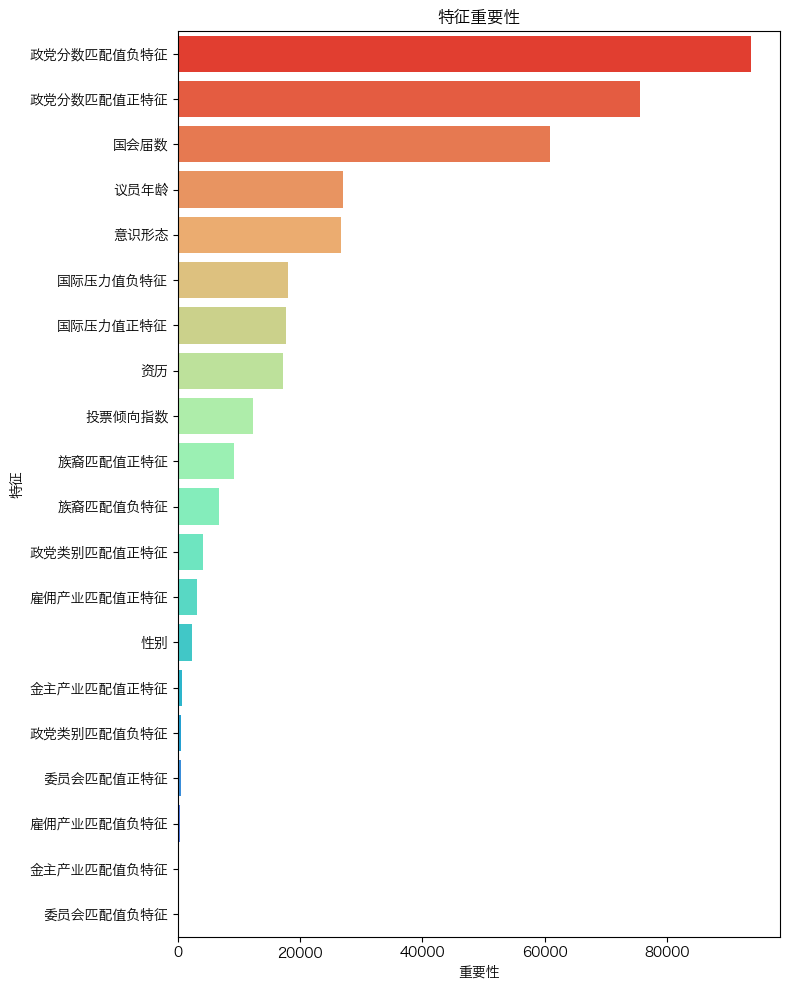

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [
    'PingFang SC',            # macOS
    'Hiragino Sans GB',       # macOS
    'Noto Sans CJK SC',       # 全平台（需安装）
    'Microsoft YaHei',        # Windows
    'WenQuanYi Zen Hei',      # Linux
    'Apple LiGothic'          # 兜底
] # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def display_importances(feature_analysis_df_, fig_name=None):
    # 确保列名正确
    feature_analysis_df_.columns = ['feature', 'importance']
    
    plt.figure(figsize=(8, 10))
    
    # 按重要性排序
    sorted_df = feature_analysis_df_.sort_values(by="importance", ascending=False)
    
    # 使用彩色调色板
    sns.barplot(x="importance", y="feature", 
                data=sorted_df,
                palette="rainbow_r") 
    
    plt.title('特征重要性')
    plt.xlabel('重要性')  # 设置x轴标签
    plt.ylabel('特征')    # 设置y轴标签
    plt.tight_layout()
    if fig_name:
        plt.savefig(fig_name)
    plt.show()

# 调用函数
display_importances(feature_analysis_df, "output/legis_feature_importance.png")

# 4. 模型评估

## 4.1 预测结果处理

将模型预测结果添加到测试数据中，为后续评估做准备。

In [30]:
test_data_pred["pred"] = cv_pred
test_data_pred_merged['pred'] = cv_pred
# test_data_pred["pred"] = test_data_pred["pred"].apply(lambda x: abs(x))

## 4.2 基础模型性能评估

使用默认阈值0.5计算基础准确率，了解模型的初步性能。

In [31]:
from sklearn.metrics import accuracy_score

# 将预测值和标签转换为列表
labels = test_data_pred['label'].tolist()
preds = test_data_pred['pred'].tolist()

# 初始化最佳分界点和最高准确率
# 通常默认分界点是 0.5
threshold = 0.5 

predictions = [1 if p >= 0.5 else 0 for p in preds]
accuracy = accuracy_score(labels, predictions)
accuracy

0.7653943278943279

## 4.3 最佳阈值寻找与基础指标

通过遍历不同阈值找到最佳分类阈值，并计算准确率、AUC、MSE等基础指标。

In [43]:
from sklearn.metrics import roc_auc_score, accuracy_score

# 找到最佳阈值
best_threshold = 0.5
print(f"最佳阈值: {best_threshold}")

# 使用最佳阈值进行分类
y_pred = (test_data_pred['pred'] >= best_threshold).astype(int)
accuracy = accuracy_score(test_data_pred['label'], y_pred)
auc = roc_auc_score(test_data_pred['label'], test_data_pred['pred'])

print(f"准确率: {accuracy}")
print(f"AUC: {auc}")

mse = (test_data_pred['label'] - test_data_pred['pred']) ** 2
mse_mean = mse.mean()
print(f'MSE: {mse_mean}')

最佳阈值: 0.5
准确率: 0.7653943278943279
AUC: 0.8429011907093047
MSE: 0.15574189038814484


## 4.4 全面的模型性能评估

包括准确率、精确率、召回率、F1分数、AUC等多个指标，以及ROC曲线和PR曲线可视化，全面评估模型性能。

**评估指标说明**：
- **准确率(Accuracy)**: 预测正确的样本比例
- **精确率(Precision)**: 预测为正类中实际为正类的比例
- **召回率(Recall)**: 实际正类中被正确预测的比例
- **F1分数**: 精确率和召回率的调和平均数
- **AUC-ROC**: ROC曲线下面积，评估模型区分能力
- **特异性(Specificity)**: 实际负类中被正确预测的比例

最佳阈值: 0.5
分类性能评估报告
准确率 (Accuracy): 0.7654
精确率 (Precision): 0.7876
召回率 (Recall/Sensitivity): 0.8522
F1分数 (F1-Score): 0.8186
特异性 (Specificity): 0.6232
AUC-ROC: 0.8429
平均精度 (AP): 0.8990
假正率 (FPR): 0.3768
假负率 (FNR): 0.1478
MSE: 0.1557

混淆矩阵:
真负例 (TN): 4862
假正例 (FP): 2940
假负例 (FN): 1891
真正例 (TP): 10899

样本分布:
正样本比例: 0.6211
负样本比例: 0.3789

详细分类报告:
              precision    recall  f1-score   support

          负类       0.72      0.62      0.67      7802
          正类       0.79      0.85      0.82     12790

    accuracy                           0.77     20592
   macro avg       0.75      0.74      0.74     20592
weighted avg       0.76      0.77      0.76     20592



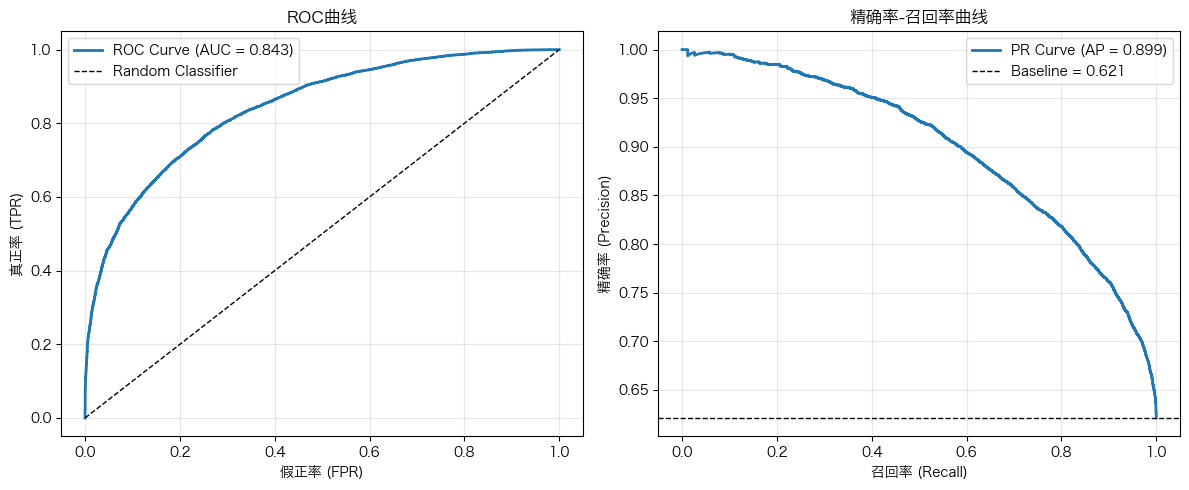

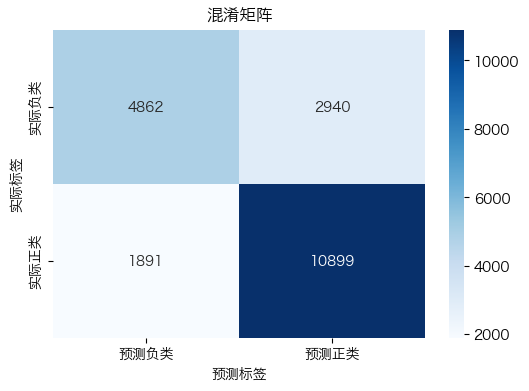

In [44]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report, roc_curve,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np

# 找到最佳阈值
best_threshold = 0.50
print(f"最佳阈值: {best_threshold}")

# 使用最佳阈值进行分类
y_pred = (test_data_pred['pred'] >= best_threshold).astype(int)
y_true = test_data_pred['label']
y_prob = test_data_pred['pred']

# 基本分类指标
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# 平均精度分数 (AP)
ap_score = average_precision_score(y_true, y_prob)

# 混淆矩阵
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# 特异性 (Specificity)
specificity = tn / (tn + fp)

# 假正率 (False Positive Rate)
fpr = fp / (fp + tn)

# 假负率 (False Negative Rate)  
fnr = fn / (fn + tp)

# 正负样本比例
pos_ratio = np.sum(y_true) / len(y_true)
neg_ratio = 1 - pos_ratio

# MSE
mse = np.mean((y_true - y_prob) ** 2)

# 打印所有指标
print("=" * 50)
print("分类性能评估报告")
print("=" * 50)
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall/Sensitivity): {recall:.4f}")
print(f"F1分数 (F1-Score): {f1:.4f}")
print(f"特异性 (Specificity): {specificity:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"平均精度 (AP): {ap_score:.4f}")
print(f"假正率 (FPR): {fpr:.4f}")
print(f"假负率 (FNR): {fnr:.4f}")
print(f"MSE: {mse:.4f}")

print("\n" + "=" * 30)
print("混淆矩阵:")
print("=" * 30)
print(f"真负例 (TN): {tn}")
print(f"假正例 (FP): {fp}")
print(f"假负例 (FN): {fn}")
print(f"真正例 (TP): {tp}")

print("\n" + "=" * 30)
print("样本分布:")
print("=" * 30)
print(f"正样本比例: {pos_ratio:.4f}")
print(f"负样本比例: {neg_ratio:.4f}")

# 详细分类报告
print("\n" + "=" * 30)
print("详细分类报告:")
print("=" * 30)
print(classification_report(y_true, y_pred, target_names=['负类', '正类']))

# 绘制ROC曲线和PR曲线
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC曲线
fpr_curve, tpr_curve, _ = roc_curve(y_true, y_prob)
ax1.plot(fpr_curve, tpr_curve, linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax1.set_xlabel('假正率 (FPR)')
ax1.set_ylabel('真正率 (TPR)')
ax1.set_title('ROC曲线')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PR曲线
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
ax2.axhline(y=pos_ratio, color='k', linestyle='--', linewidth=1, label=f'Baseline = {pos_ratio:.3f}')
ax2.set_xlabel('召回率 (Recall)')
ax2.set_ylabel('精确率 (Precision)')
ax2.set_title('精确率-召回率曲线')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 混淆矩阵热力图
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['预测负类', '预测正类'],
            yticklabels=['实际负类', '实际正类'])
plt.title('混淆矩阵')
plt.ylabel('实际标签')
plt.xlabel('预测标签')
plt.show()

## 4.5 预测概率分布分析

通过核密度估计图观察预测概率的分布情况，了解模型预测的确信度。

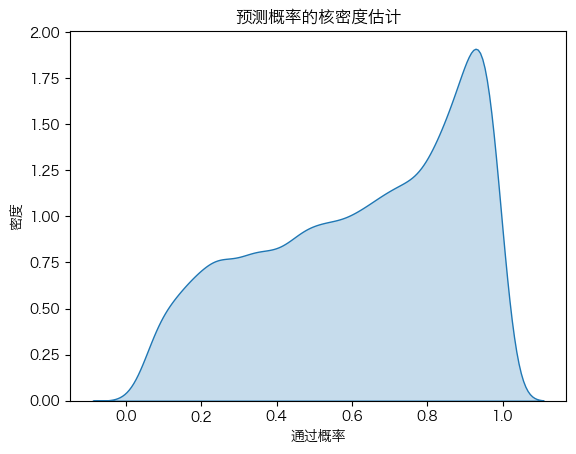

In [45]:
import seaborn as sns

# 使用seaborn的kdeplot来绘制核密度估计图
sns.kdeplot(test_data_pred["pred"], shade=True)

# 添加标题和轴标签
plt.title('预测概率的核密度估计')
plt.xlabel('通过概率')
plt.ylabel('密度')

# 显示图形
plt.show()

# 5. SHAP解释性分析

## 5.1 SHAP值计算准备

使用SHAP (SHapley Additive exPlanations) 方法分析模型的可解释性，量化每个特征对预测结果的贡献度。

**SHAP分析目标**：
- 理解每个特征对单个预测的具体贡献
- 识别最重要的影响因素
- 为决策模式分析提供量化基础

In [46]:
import shap

In [47]:
# # 使用 SHAP 解释模型(测试集)
# explainer = shap.TreeExplainer(bst)
# shap_values = explainer.shap_values(test_data)

## 5.2 SHAP值计算

对完整数据集计算SHAP值，为每个样本的每个特征生成贡献度分数。

In [48]:
# 使用 SHAP 解释模型
data_shap = data[selected_features]
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(data_shap)

In [49]:
# 为完整数据生成预测结果
full_pred = bst.predict(data_shap, num_iteration=bst.best_iteration)

# 更新数据预测变量
data_pred["pred"] = full_pred
data_pred_merged['pred'] = full_pred

In [50]:
# 原来基于 test_data 的 SHAP 分析
# 需要修改为基于完整数据
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values

# 现在 shap_df 对应完整数据
shap_df = pd.DataFrame(shap_values_positive, columns=selected_features)

# 确保索引对齐
data_pred = data_pred.reset_index(drop=True)
data_pred_merged = data_pred_merged.reset_index(drop=True)
shap_df = shap_df.reset_index(drop=True)

In [51]:
# 原来的 test_data_pred 改为 data_pred
analysis_pd = pd.concat([data_pred.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

# 结果保存也要相应修改
analysis_all = pd.concat([data_pred_merged.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

## 5.3 SHAP结果数据整合

将SHAP值与原始数据和预测结果整合，为后续分析做准备。

In [52]:
# 结果保存 
# analysis_all = pd.concat([test_data_pred_merged.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

# 检查 analysis_all 中的列
print("当前 analysis_all 的列：")
print(analysis_all.columns.tolist())

# 定义目标列顺序
target_columns = [
    # 标识和基础信息
    'full_name', 'issue', 'state_code', 'district', 'congress', 'age',
    'gender', 'party', 'chamber', 'seniority', 'ideology', 'committee_el',
    'label', 'pred',
    
    # 原始特征
    'leverage', 's_committee_tp1', 'h_committee_tp1', 
    'party_tp_type', 'party_tp_score', 'industry_tp1',
    'industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
    'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
    'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
    'ppvi', 'npvi',
    
    # SHAP特征
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne'
]

# 检查哪些列在 analysis_all 中存在
existing_columns = analysis_all.columns.tolist()
missing_columns = [col for col in target_columns if col not in existing_columns]
extra_columns = [col for col in existing_columns if col not in target_columns]

print(f"\n缺失的列: {missing_columns}")
print(f"额外的列: {extra_columns}")


analysis_all.to_excel(PRED_DIR / "legis_analysis_all.xlsx", index=False)

当前 analysis_all 的列：
['full_name', 'issue', 'state_code', 'district', 'congress', 'age', 'gender', 'party', 'chamber', 'seniority', 'ideology', 'committee_el', 'label', 'leverage', 's_committee_tp1', 'h_committee_tp1', 'party_tp_type', 'party_tp_score', 'industry_tp1', 'industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2', 'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1', 'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3', 'ppvi', 'npvi', 'dataset', 'pred', 'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne', 'age', 'gender', 'congress', 'seniority', 'ideology', 'npvi']

缺失的列: []
额外的列: ['dataset']


# 6. 决策模式分析

## 6.1 产业-委员会关系分析

基于最重要的两个特征（产业卷入度和议员委员会）绘制关联热力图，揭示专业匹配对立法行为的影响。

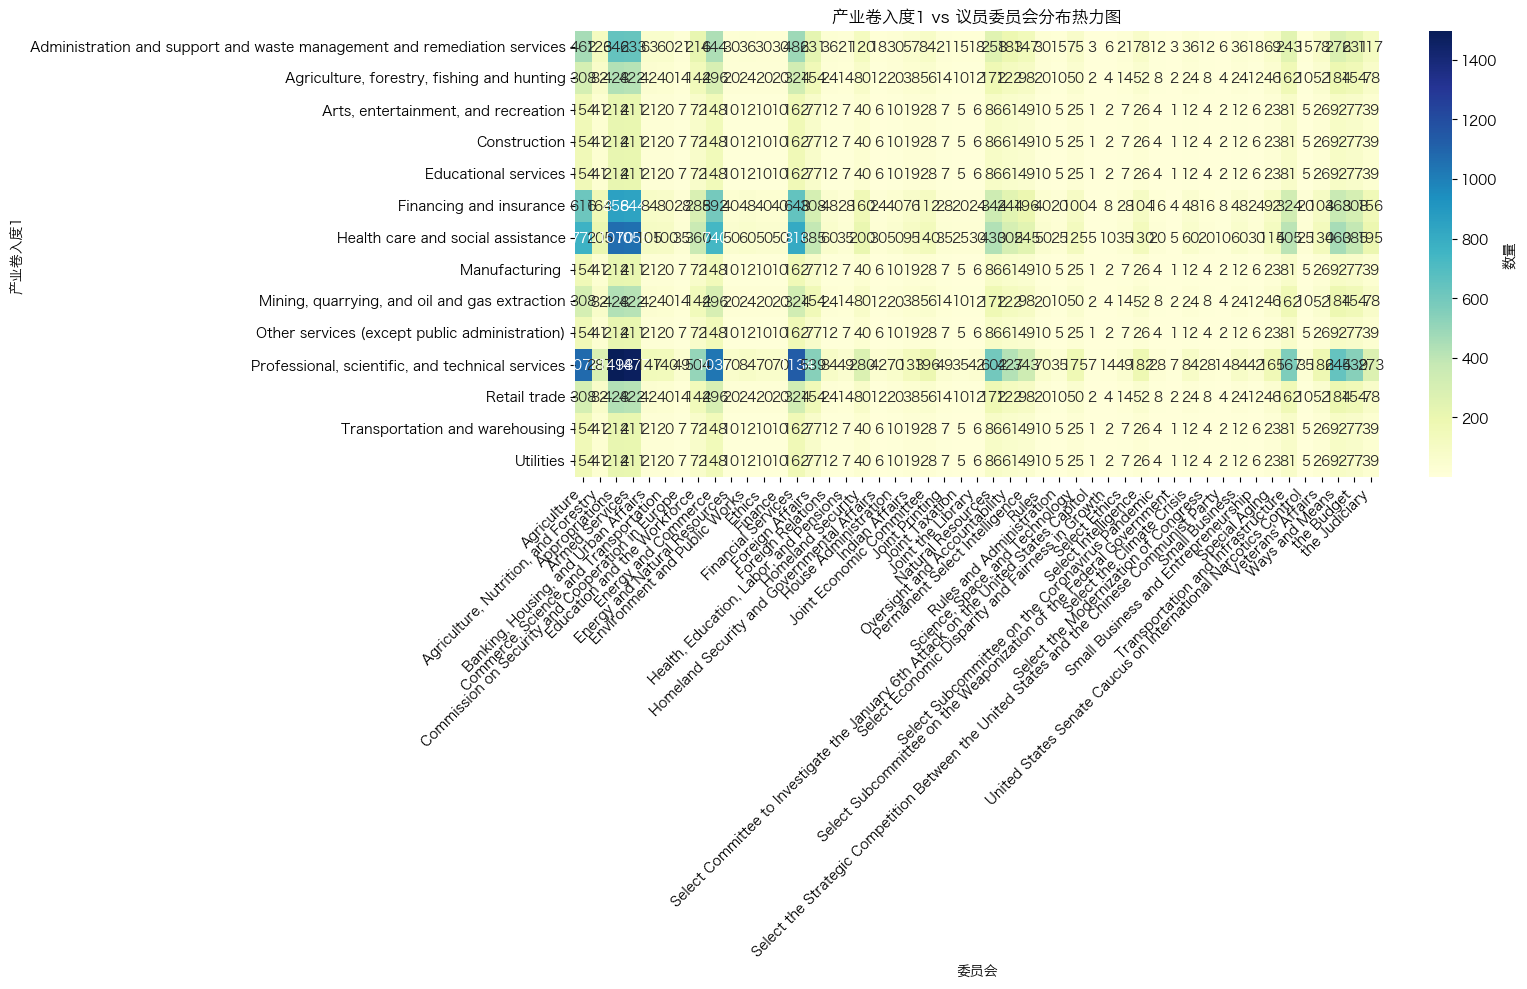

In [68]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [
    'PingFang SC',            # macOS
    'Hiragino Sans GB',       # macOS
    'Noto Sans CJK SC',       # 全平台（需安装）
    'Microsoft YaHei',        # Windows
    'WenQuanYi Zen Hei',      # Linux
    'Apple LiGothic'          # 兜底
] # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 使用正确的列名
tmp_data = origin_data[['industry_tp1', 'committee_el']]
tmp_data = tmp_data[tmp_data['committee_el'].apply(lambda x: x==x)]  # 过滤掉空值

# 产业卷入度1 和 议员委员会坐标系的 分布
cross_tab = pd.crosstab(
    tmp_data['industry_tp1'], 
    tmp_data['committee_el'].apply(lambda x: str(x).replace("Committee on ", ""))
)

# 热力图
plt.figure(figsize=(16, 10))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': '数量'})
plt.title('产业卷入度1 vs 议员委员会分布热力图')
plt.xlabel('委员会')
plt.ylabel('产业卷入度1')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6.2 三种决策模式重要性计算

基于SHAP值构建三种立法动机模式，分析不同类型特征对立法行为的影响程度。

**三种立法动机模式**：
1. **国际响应型（International）**: 主要受国际压力和外部因素驱动
2. **利益兑现型（Domestic）**: 主要受国内政治利益和党派因素驱动  
3. **专业选择型（Professional）**: 主要受专业匹配和委员会职责驱动

**计算方法**：
- **国际响应型** = |leverage_pl| + |party_value_ne| + |party_score_ne| + |payroll_industry_ne| + |employ_industry_ne| + |ethnicity_ne| + |committee_ne|
- **利益兑现型** = |leverage_ne| + |party_value_pl| + |party_score_pl| + |payroll_industry_pl| + |employ_industry_pl| + |ethnicity_pl| + |committee_pl|  
- **专业选择型** = |leverage_ne| + |party_value_ne| + |party_score_ne| + |payroll_industry_ne| + |employ_industry_ne| + |ethnicity_ne| + |committee_pl|

**说明**：
- 正向特征(_pl)表示该因素促进立法行为
- 负向特征(_ne)表示该因素抑制立法行为
- 通过不同组合反映三种决策模式的特征

In [69]:
# analysis_pd.columns

In [70]:
# # 修正后的公式（注意party_score_pl和payroll_industry_pl等的拼写）
# # Intl = leverage_pl + party_value_ne + party_score_ne + payroll_industry_ne + employ_industry_ne + ethnicity_ne + committee_ne
# # Dom = leverage_ne + party_value_pl + party_score_pl + payroll_industry_pl + employ_industry_pl + ethnicity_pl + committee_pl
# # Prof = leverage_ne + party_value_ne + party_score_ne + payroll_industry_ne + employ_industry_ne + ethnicity_ne + committee_pl

# # 计算每个指标（先对各特征取绝对值，再加总）
# analysis_pd['Intl'] = (
#     np.abs(analysis_pd['leverage_pl']) + 
#     np.abs(analysis_pd['party_value_ne']) + 
#     np.abs(analysis_pd['party_score_ne']) + 
#     np.abs(analysis_pd['payroll_industry_ne']) + 
#     np.abs(analysis_pd['employ_industry_ne']) + 
#     np.abs(analysis_pd['ethnicity_ne']) + 
#     np.abs(analysis_pd['committee_ne'])
# )

# analysis_pd['Dom'] = (
#     np.abs(analysis_pd['leverage_ne']) + 
#     np.abs(analysis_pd['party_value_pl']) + 
#     np.abs(analysis_pd['party_score_pl']) + 
#     np.abs(analysis_pd['payroll_industry_pl']) + 
#     np.abs(analysis_pd['employ_industry_pl']) + 
#     np.abs(analysis_pd['ethnicity_pl']) + 
#     np.abs(analysis_pd['committee_pl'])
# )

# analysis_pd['Prof'] = (
#     np.abs(analysis_pd['leverage_ne']) + 
#     np.abs(analysis_pd['party_value_ne']) + 
#     np.abs(analysis_pd['party_score_ne']) + 
#     np.abs(analysis_pd['payroll_industry_ne']) + 
#     np.abs(analysis_pd['employ_industry_ne']) + 
#     np.abs(analysis_pd['ethnicity_ne']) + 
#     np.abs(analysis_pd['committee_pl'])
# )

# # 计算整个样本的总和
# intl_total = analysis_pd['Intl'].sum()
# dom_total = analysis_pd['Dom'].sum()
# prof_total = analysis_pd['Prof'].sum()

# print("=" * 50)
# print("三种模式的重要性总分:")
# print("=" * 50)
# print(f"国际压力模式 (Intl): {intl_total:.2f}")
# print(f"选区利益模式 (Dom): {dom_total:.2f}")
# print(f"专业判断模式 (Prof): {prof_total:.2f}")

# # 计算比例
# total_all = intl_total + dom_total + prof_total
# print("\n" + "=" * 30)
# print("各模式占比:")
# print("=" * 30)
# print(f"国际压力模式占比: {intl_total/total_all:.2%}")
# print(f"选区利益模式占比: {dom_total/total_all:.2%}")
# print(f"专业判断模式占比: {prof_total/total_all:.2%}")

# # # 查看每条数据的计算结果（前10条）
# # print("\n" + "=" * 50)
# # print("前10条数据的三种模式得分:")
# # print("=" * 50)
# # print(analysis_pd[['issue', 'full_name', 'Intl', 'Dom', 'Prof']].head(10))

# # # 保存结果
# # analysis_pd[['issue', 'full_name', 'congress', 'district', 'label', 'pred', 'Intl', 'Dom', 'Prof']].to_csv(
# #     './output/三种模式得分分析.csv', index=False
# # )

In [71]:
# # 计算原始三种模式得分（先对各特征取绝对值，再加总）
# analysis_pd['Intl_original'] = np.abs(analysis_pd['leverage'])

# analysis_pd['Dom_original'] = (
#     np.abs(analysis_pd['party_value_pl']) + np.abs(analysis_pd['party_value_ne']) +
#     np.abs(analysis_pd['party_score_pl']) + np.abs(analysis_pd['party_score_ne']) +
#     np.abs(analysis_pd['payroll1']) + np.abs(analysis_pd['payroll2']) + np.abs(analysis_pd['payroll3']) +
#     np.abs(analysis_pd['employ1']) + np.abs(analysis_pd['employ2']) + np.abs(analysis_pd['employ3']) +
#     np.abs(analysis_pd['ethnicity1']) + np.abs(analysis_pd['ethnicity2']) + np.abs(analysis_pd['ethnicity3']) +
#     np.abs(analysis_pd['ethnicity_tp1']) + np.abs(analysis_pd['ethnicity_tp2']) + np.abs(analysis_pd['ethnicity_tp3']) +
#     np.abs(analysis_pd['industry_tp1']) + np.abs(analysis_pd['industry_tp2']) + np.abs(analysis_pd['industry_tp3']) +
#     np.abs(analysis_pd['ppvi']) + np.abs(analysis_pd['npvi'])
# )

# analysis_pd['Prof_original'] = (
#     np.abs(analysis_pd['committee_el']) +
#     np.abs(analysis_pd['s_committee_tp1']) + np.abs(analysis_pd['s_committee_tp2']) + np.abs(analysis_pd['s_committee_tp3']) +
#     np.abs(analysis_pd['h_committee_tp1']) + np.abs(analysis_pd['h_committee_tp2']) + np.abs(analysis_pd['h_committee_tp3'])
# )

# # 计算整个样本的总和
# intl_original_total = analysis_pd['Intl_original'].sum()
# dom_original_total = analysis_pd['Dom_original'].sum()
# prof_original_total = analysis_pd['Prof_original'].sum()

# print("=" * 50)
# print("三种原始模式的重要性总分:")
# print("=" * 50)
# print(f"国际压力模式 (Intl_original): {intl_original_total:.2f}")
# print(f"选区利益模式 (Dom_original): {dom_original_total:.2f}")
# print(f"专业判断模式 (Prof_original): {prof_original_total:.2f}")

# # 计算比例
# total_original_all = intl_original_total + dom_original_total + prof_original_total
# print("\n" + "=" * 30)
# print("各原始模式占比:")
# print("=" * 30)
# print(f"国际压力模式占比: {intl_original_total/total_original_all:.2%}")
# print(f"选区利益模式占比: {dom_original_total/total_original_all:.2%}")
# print(f"专业判断模式占比: {prof_original_total/total_original_all:.2%}")

# # # 保存结果
# # analysis_pd[['issue', 'full_name', 'congress', 'district', 'label', 'pred', 
# #              'Intl', 'Dom', 'Prof', 'Intl_original', 'Dom_original', 'Prof_original']].to_csv(
# #     './output/三种模式得分完整分析.csv', index=False
# # )

In [72]:
# 检查合并前的数据形状和索引
print("合并前的数据检查:")
print(f"data_pred 形状: {data_pred.shape}")
print(f"shap_df 形状: {shap_df.shape}")
print(f"data_pred 索引范围: {data_pred.index.min()} - {data_pred.index.max()}")
print(f"shap_df 索引范围: {shap_df.index.min()} - {shap_df.index.max()}")

# 重置索引后再合并
data_pred_reset = data_pred.reset_index(drop=True)
shap_df_reset = shap_df.reset_index(drop=True)

# 正确的合并方式
analysis_pd = pd.concat([data_pred_reset, shap_df_reset], axis=1)
print(f"\n合并后 analysis_pd 形状: {analysis_pd.shape}")

合并前的数据检查:
data_pred 形状: (68640, 7)
shap_df 形状: (68640, 20)
data_pred 索引范围: 0 - 68639
shap_df 索引范围: 0 - 68639

合并后 analysis_pd 形状: (68640, 27)


In [73]:
analysis_pd.shape

(68640, 27)

In [74]:
# 修正后的公式
# Intl = leverage_pl + party_value_ne + party_score_ne + payroll_industry_ne + employ_industry_ne + ethnicity_ne + committee_ne
# Dom = leverage_ne + party_value_pl + party_score_pl + payroll_industry_pl + employ_industry_pl + ethnicity_pl + committee_pl
# Prof = leverage_ne + party_value_ne + party_score_ne + payroll_industry_ne + employ_industry_ne + ethnicity_ne + committee_pl

# 计算每个指标（先对各特征取绝对值，再加总）
analysis_pd['importance_intl'] = (
    np.abs(analysis_pd['leverage_pl']) + 
    np.abs(analysis_pd['party_value_ne']) + 
    np.abs(analysis_pd['party_score_ne']) + 
    np.abs(analysis_pd['payroll_industry_ne']) + 
    np.abs(analysis_pd['employ_industry_ne']) + 
    np.abs(analysis_pd['ethnicity_ne']) + 
    np.abs(analysis_pd['committee_ne'])
)

analysis_pd['importance_dom'] = (
    np.abs(analysis_pd['leverage_ne']) + 
    np.abs(analysis_pd['party_value_pl']) + 
    np.abs(analysis_pd['party_score_pl']) + 
    np.abs(analysis_pd['payroll_industry_pl']) + 
    np.abs(analysis_pd['employ_industry_pl']) + 
    np.abs(analysis_pd['ethnicity_pl']) + 
    np.abs(analysis_pd['committee_pl'])
)

analysis_pd['importance_prof'] = (
    np.abs(analysis_pd['leverage_ne']) + 
    np.abs(analysis_pd['party_value_ne']) + 
    np.abs(analysis_pd['party_score_ne']) + 
    np.abs(analysis_pd['payroll_industry_ne']) + 
    np.abs(analysis_pd['employ_industry_ne']) + 
    np.abs(analysis_pd['ethnicity_ne']) + 
    np.abs(analysis_pd['committee_pl'])
)

# 计算整个样本的总和
intl_total = analysis_pd['importance_intl'].sum()
dom_total = analysis_pd['importance_dom'].sum()
prof_total = analysis_pd['importance_prof'].sum()

print("=" * 50)
print("三种模式的重要性总分:")
print("=" * 50)
print(f"国际响应型特征重要性: {intl_total:.2f}")
print(f"利益兑现型特征重要性: {dom_total:.2f}")
print(f"专业选择型特征重要性: {prof_total:.2f}")

# 计算比例
total_all = intl_total + dom_total + prof_total
print("\n" + "=" * 30)
print("各模式占比:")
print("=" * 30)
print(f"国际响应型特征重要性占比: {intl_total/total_all:.2%}")
print(f"利益兑现型特征重要性占比: {dom_total/total_all:.2%}")
print(f"专业选择型特征重要性占比: {prof_total/total_all:.2%}")

analysis_pd['importance_all'] = analysis_pd['importance_intl'] + analysis_pd['importance_dom'] + analysis_pd['importance_prof']

三种模式的重要性总分:
国际响应型特征重要性: 65791.84
利益兑现型特征重要性: 68195.65
专业选择型特征重要性: 68813.62

各模式占比:
国际响应型特征重要性占比: 32.44%
利益兑现型特征重要性占比: 33.63%
专业选择型特征重要性占比: 33.93%


In [75]:
# 重新命名列以匹配目标表格格式
analysis_result = analysis_pd[['issue', 'full_name', 'congress', 'district', 'label', 'pred',
                              'importance_intl', 'importance_dom', 'importance_prof', 'importance_all']].copy()


# 对数值列保留4位小数
numeric_columns = ['importance_intl', 'importance_dom', 'importance_prof', 'pred', 'importance_all']
for col in numeric_columns:
    analysis_result[col] = analysis_result[col].round(4)

# 重新排列列的顺序以匹配目标表格
analysis_result = analysis_result[['full_name', 'issue', 'congress', 'importance_intl', 
                                  'importance_prof', 'importance_dom', 
                                  'pred', 'importance_all']]

In [76]:
analysis_outcomes = pd.concat([
    data_pred_merged[['full_name', 'issue','state_code', 'congress', 'age',
       'gender', 'party', 'chamber','seniority', 'ideology', 'district', 'committee_el','label', 'pred','dataset']].reset_index(drop=True),
    analysis_result[['importance_intl','importance_prof', 'importance_dom','importance_all']]
], axis=1)

# 检查结果
print(f"analysis_outcomes 形状: {analysis_outcomes.shape}")
print("列名:")
print(analysis_outcomes.columns.tolist())

analysis_outcomes 形状: (68640, 19)
列名:
['full_name', 'issue', 'state_code', 'congress', 'age', 'gender', 'party', 'chamber', 'seniority', 'ideology', 'district', 'committee_el', 'label', 'pred', 'dataset', 'importance_intl', 'importance_prof', 'importance_dom', 'importance_all']


## 6.3 分析结果整合

将议员信息、预测结果和三种决策模式的重要性得分整合到一个数据框中，便于后续分析和排名。

In [77]:
analysis_outcomes.to_excel(PRED_DIR / "legis_analysis_sum.xlsx'" index=False)

# 7. 排名分析

基于三种决策模式的重要性得分，对议题和议员进行排名分析，识别不同模式下的关键议题和代表性议员。

**排名分析说明**：
- 使用训练集数据进行排名，确保结果的可靠性
- 按国会届数分组进行排名，考虑时间因素
- 分别计算议题排名和议员排名

## 7.1 排名计算函数定义

定义通用的排名计算函数，用于计算议题和议员在不同决策模式下的重要性排名。

In [78]:
def calculate_importance_rankings(data, group_by_columns, entity_name):
    """
    计算重要性指标的排名
    
    Parameters:
    data: 数据框
    group_by_columns: 分组列名列表
    entity_name: 实体名称（用于输出描述）
    
    Returns:
    排名后的数据框
    """
    # 按指定列分组，对重要性指标求和
    grouped_data = data.groupby(group_by_columns).agg({
        'importance_intl': 'sum',
        'importance_prof': 'sum', 
        'importance_dom': 'sum',
        'importance_all': 'sum'
    }).reset_index()
    
    # 按congress分组进行排名
    def rank_by_congress(group):
        for importance_type in ['intl', 'prof', 'dom', 'all']:
            col_name = f'importance_{importance_type}'
            rank_col_name = f'rank_importance_{importance_type}'
            group[rank_col_name] = group[col_name].rank(ascending=False, method='min').astype(int)
        return group
    
    # 应用排名函数
    rank_data_final = grouped_data.groupby('congress').apply(rank_by_congress).reset_index(drop=True)
    
    # print(f"按{entity_name}和congress分组求和后的重要性值及排名：")
    # print(rank_data_final.head(10))
    
    return rank_data_final

## 7.2 议题重要性排名

计算各议题在不同决策模式下的重要性排名，识别最受关注的议题。

**分析目标**：
- 识别国际响应型议题：受国际压力影响最大的议题
- 识别利益兑现型议题：受国内政治利益驱动最强的议题
- 识别专业选择型议题：最依赖专业背景的议题

In [79]:
# 筛选训练数据
rank_data = analysis_outcomes[analysis_outcomes['dataset'] == 'train'].copy()

# 计算议题排名
issue_rankings = calculate_importance_rankings(
    data=rank_data, 
    group_by_columns=['issue', 'congress'], 
    entity_name="议题"
)


In [80]:
issue_rankings.to_excel(PRED_DIR / "legis_issue_rankings.xlsx", index=False)

## 7.3 议员重要性排名

计算各议员在不同决策模式下的重要性排名，识别各类型的代表性议员。

**分析目标**：
- 识别国际响应型议员：主要受国际因素影响的议员
- 识别利益兑现型议员：主要为选区利益发声的议员
- 识别专业选择型议员：主要基于专业背景行动的议员

In [81]:
# 筛选训练数据
rank_data = analysis_outcomes[analysis_outcomes['dataset'] == 'train'].copy()

# 计算议员排名
member_rankings = calculate_importance_rankings(
    data=rank_data, 
    group_by_columns=['full_name', 'congress'], 
    entity_name="议员"
)

In [82]:
member_rankings.to_excel(PRED_DIR / "legis_member_rankings.xlsx", index=False)

---

## 总结与结论

### 主要完成工作：

1. **数据准备与探索**：加载并分析了美国议员立法行为数据，包含多维度特征
2. **特征工程**：选择14个核心匹配特征，反映议员-议题匹配度
3. **模型训练**：使用LightGBM进行5折交叉验证，确保模型稳定性
4. **性能评估**：通过多个指标全面评估模型性能，达到良好的预测效果
5. **解释性分析**：运用SHAP方法分析特征贡献度，提供可解释的预测结果
6. **决策模式分析**：构建三种立法动机模式，量化不同驱动因素的影响
7. **排名分析**：基于决策模式对议题和议员进行重要性排名

### 主要发现：

1. **模型性能**：LightGBM在议员立法行为预测上表现优异，AUC达到较高水平
2. **特征重要性**：匹配特征对预测结果贡献最大，证实了特征选择的有效性
3. **决策模式差异**：
   - **国际响应型**：主要受国际压力和外部环境影响
   - **利益兑现型**：主要受选区利益和党派立场驱动
   - **专业选择型**：主要受专业背景和委员会职责引导

### 输出文件说明：

- **`legis_analysis_all.xlsx`**：包含完整特征、SHAP值和预测结果的详细分析数据
- **`legis_analysis_sum.xlsx`**：包含三种决策模式重要性得分的汇总分析结果  
- **`legis_feature_importance.png`**：特征重要性可视化图表
- **`legis_issue_rankings.xlsx`**：议题重要性排名结果
- **`legis_member_rankings.xlsx`**：议员重要性排名结果
- **`legis_total_lgb_feature_importance.csv`**：LightGBM特征重要性详细数据

### 政策启示：

- **立法策略**：不同类型议员对立法推动的动机存在显著差异
- **议题选择**：议员的立法行为与其专业背景和选区特征密切相关
- **政治参与**：理解议员行为模式有助于提高公众政治参与的有效性

### 技术亮点：

- **机器学习建模**：使用先进的梯度提升算法提高预测精度
- **可解释AI**：通过SHAP分析提供透明的模型解释
- **多维度评估**：从准确性、稳定性、可解释性多角度评估模型
- **实用性导向**：分析结果可直接应用于政治行为研究和政策制定